# Inhalt
1. [Untersuchung der Indizes](#IndexBerechnungen)<br />
1.1. [Datenimport](#Datenimport)<br />
1.2. [Wechselkurse](#Wechselkurse) <br />
1.3. [Erstellung Laenderpaare und Berechnung der Korrelationen](#LaenderpaareKorrelationen)<br />
1.4. [Berechnung Regressionen](#BerechnungRegressionen)<br />
1.5. [Auswertung der Regression](#AuswertungRegression)<br />
<br />
2. [Analyse der Handelsdaten](#AnalyseHandelsdaten) <br />
2.1. [Vorbereitung der Handelsdaten](#VorbereitungDatenHandel) <br />
2.2. [Zusammenhang Korrelation und Gesamthandel](#ZusammenhangKorrelationGesamthandel) <br />
2.2.1. [Auswertung](#AuswertungKorrelationGesamthandel)<br />
2.2.2. [Untersuchung Ursache und Wirkung](#GesamthandelUrsacheEffekt) <br />
2.3. [Zusammenhang Korrelation und relative wirtschaftliche Integration](#KorrelationIntegration) <br/>
2.3.1. [Auswertung](#AuswertungIntegration)<br/>
2.3.2.[Untersuchung Ursache und Wirkung](#UrsacheWirkungIntegration)<br/>
<br/>
3. Interaktive Darstellungen <br/>
3.1. [gleitende Korrelation eines Länderpaares](#interactivegleitendeKor)<br/>
3.2. [Modell eines Portfolios mit 2 Anlagen](#interactivePortfolio) <br/>
3.3. [interaktive Darstellung Indexkorrelation und Globalisierungsindikator](#interactiveLaender) <br/>
<br/>
0. [Sonstiges/Anhang/Experimente](#sonstiges)
<a id='Example'></a>

In [27]:
#import libraries

#essentielle Pakete
import matplotlib.pyplot as plt
from matplotlib import lines
import matplotlib
import pandas as pd
import numpy as np

#Analysetools
#import pylab as pl
import seaborn as sns
#from sklearn.linear_model import LinearRegression
#import datetime as dt
import scipy as sp
import statsmodels.api as sm

#usability
from tqdm import tqdm_notebook as tqdm
import ipywidgets as widgets

#Daten Yahoo Finance
from yahoofinancials import YahooFinancials

In [28]:
import import_historical_prices as ih

## Index Berechnungen
<a id='IndexBerechnungen'></a>

In [29]:
#Funktion für schnelle Umwandlung der Indexsymbole zu Indexnamen
def to_name(stock):
    temp = index_names[symbols.index(stock)]
    return temp

In [30]:
#deutsche Übersetzung der Ländernamen für Visualisierungen
country_translations = {'USA' : "Vereinigte Staaten",
 'UK':"Vereinigtes Königreich",
 'Germany':"Deutschland",
 'Austria':"Österreich",
 'France':"Frankreich",
 'Switzerland':"Schweiz",
 'Netherlands':"Niederlande",
 'Belgium':"Belgien",
 'Japan':"Japan",
 'HongKong':"Hong Kong",
 'China':"China",
 'Singapore':"Singapur",
 'Australia':"Australien",
 'India':"Indien",
 'Indonesia':"Indonesien",
 'Malaysia':"Malaysia",
 'SouthKorea':"Südkorea",
 'Canada':"Kanada",
 'Mexico':"Mexiko"}

def translate_countries(country_list):
    
    if type(country_list) == list:
        new_list = []
        for element in country_list:
            new_list.append(country_translations[element])
        return new_list
    else:
        return country_translations[country_list]

In [31]:
#Länderklassifizierung 
#Quelle: IHS Markit: https://indices.ihsmarkit.com/EMIX/Download/ViewMethodologyPdf?key=CCM

country_classification = {
'USA':"Developed",
 'UK':"Developed",
 'Germany':"Developed",
 'Austria':"Developed",
 'France':"Developed",
 'Switzerland':"Developed",
 'Netherlands':"Developed",
 'Belgium':"Developed",
 'Japan':"Developed",
 'HongKong':"Developed",
 'China':"Emerging",
 'Singapore':"Developed",
 'Australia':"Developed",
 'India':"Emerging",
 'Indonesia':"Emerging",
 'Malaysia':"Emerging",
 'SouthKorea':"Emerging",
 'Canada':"Developed",
 'Mexico':"Emerging",
}

### Import der Daten
<a id='Datenimport'></a>

In [32]:
#import world indices
indices = pd.read_excel("Data/Indices.xlsx") #read excel sheet
indices.set_index("Name", inplace = True) #set readable name as index 
indices["Foundation"]=indices["Foundation"].astype(int) #convert year from float to integer

#(temporarily) remove certain indeces
#indizes mit zur kurzer Historie: nach 1992 (diese wurden ursprünglich mit verwendet, haben aber eine zu kurze Dauer)
remove = ["EGX 30 Price Return Index", "RTS Index"] + ['TA-125','IBEX 35', 'FTSE/JSE All-Share Index', 'TSEC weighted index', 'FTSE MIB Index',"Jakarta Composite Index"]
for element in indices.index:
    if element in remove:
        indices = indices.drop(element)

In [33]:
indices

,RIC (Reuters Instrument Code),Country,Currency,Foundation,Sources,File,Quelle
Name,,,,,,,
S&P 500,^GSPC,USA,USD,1926,Yahoo Finance,NaN,NaN
FTSE 100,^FTSE,UK,GBP,1984,Yahoo Finance,NaN,NaN
DAX Kursindex,^GDAXIP,Germany,EUR,1988,Boerse.de,DAX_historisch.csv,https://www.boerse.de/historische-kurse/DAX-Ku...
Austrian Trading Index,^ATX,Austria,EUR,1991,Wiener Börse,ATX_historisch.csv,https://www.wienerborse.at/indizes/aktuelle-in...
CAC 40,^FCHI,France,EUR,1987,Yahoo Finance,NaN,NaN
Swiss Market Index,^SSMI,Switzerland,CHF,1988,Yahoo Finance,NaN,NaN
AEX-Index,^AEX,Netherlands,EUR,1983,Stooq,AEX_historisch.csv,https://stooq.com/q/d/?s=^aex&i=d&l=237
BEL 20,^BFX,Belgium,EUR,1990,Yahoo Finance,NaN,NaN
Nikkei 225,^N225,Japan,JPY,1950,Yahoo Finance,NaN,NaN


In [34]:
len(indices["Country"].to_list())

18

In [35]:
#create list for later use from dataframe
symbols = indices["RIC (Reuters Instrument Code)"].to_list()
index_names = indices.index.to_list()
countries = indices["Country"].to_list()

#create dictionaries, um Übersetzungen leichter zu machen und schneller durchzuführen
symbol_to_name = {}
name_to_symbol = {}
name_to_country = {}
symbol_to_country = {}
for element in symbols:
    symbol_to_name[element]=to_name(element)
    name_to_symbol[symbol_to_name[element]]=element
    symbol_to_country[element]=countries[symbols.index(element)]
    name_to_country[symbol_to_name[element]]=symbol_to_country[element]

In [36]:
#remove not needed countries from usability dictionaries
for element in list(country_classification.keys()):
    if element not in countries:
        del country_classification[element]
        
for element in list(country_translations.keys()):
    if element not in countries:
        del country_translations[element]

In [37]:
#Indizes, welche über csv-files geladen werden
manual = ["^GDAXIP","^ATX","^AEX","^SSEC","^BSESN","^KS11"] 
ticker = symbols[:]
for element in manual:
    del ticker[ticker.index(element)]

#Parameter für das Herunterladen der Daten
 
freq = "daily" #daily, weekly or monthly

#automatically add today
#today = dt.datetime.today().strftime("%Y-%m-%d") #convert date to required format

#Start- und Enddatum der Daten wählen
start_day = "1992-01-07"
end_day = "2020-04-01"

ticker_yahoofinancials = YahooFinancials(ticker)
ticker_his = ticker_yahoofinancials.get_historical_price_data(start_day,"2020-05-01",freq)

In [38]:
data = dict.fromkeys(symbols, 0)

#clean data
not_added=[] #list elements that were not added due to no availability of data
for element in symbols:
    
    if element in manual: #skip symbole die manuell eingefügt werden
        continue
        
    #Daten werden von der YahooFinance Bibliothek in ein dict-Format gespeichert 
    # - diese werden nun für jeden Index in dataframe gesammelt und in dict sortiert
    try:
        df = pd.DataFrame(ticker_his[element]["prices"])
        df = df[["formatted_date","close","high","low","volume"]] #only closing prices
        df.rename(columns = {"formatted_date":"date"}, inplace = True) 
        #df.rename(columns = {"close":element}, inplace = True)
        df["date"]=pd.to_datetime(df["date"])
        df.set_index("date", inplace = True)
        data[element]=df
        data[element]["close"].fillna(method = "backfill", inplace = True)
        print("Added {}".format(element))
    except:
        not_added.append(element) 
        
for element in symbols:
    if element in not_added:
        del index_names[symbols.index(element)]
        del symbols[symbols.index(element)]
        del data[element]
        
#Manuell eingelesene Daten in dict bringen         
data["^GDAXIP"]=ih.import_dax()
data["^AEX"]=ih.import_aex()
data["^ATX"]=ih.import_atx()
data["^SSEC"]=ih.import_sse()
data["^KS11"]=ih.import_kospi()
data["^BSESN"]=ih.import_bse()

for element in manual:
    print("Added {}".format(element))

Added ^GSPC
Added ^FTSE
Added ^FCHI
Added ^SSMI
Added ^BFX
Added ^N225
Added ^HSI
Added ^STI
Added ^AORD
Added ^KLSE
Added ^GSPTSE
Added ^MXX
Added ^GDAXIP
Added ^ATX
Added ^AEX
Added ^SSEC
Added ^BSESN
Added ^KS11


In [39]:
#Malaysian stock index manuell hinzufügen um Datenlücke bei Yahoo Finance zu füllen
klse1 = ih.import_klse().rename(columns = {"close":"close1"})
klse1.index = pd.to_datetime(klse1.index)
klse2 = pd.DataFrame(data["^KLSE"]["close"]).rename(columns = {"close":"close2"})
klse2.index = pd.to_datetime(klse2.index)

klse_df = pd.concat([klse1,klse2], join = "outer", sort = False)

klse_df = klse_df.groupby(by = klse_df.index).max()
klse_df["new"]=klse_df.max(axis=1)

data["^KLSE"] = pd.DataFrame(klse_df["new"]).rename(columns = {"new":"close"})

In [40]:
#alle Indizes an gleichen Zeitraum anpassen
for element in data.keys():
    data[element] = data[element].loc[start_day:end_day]
    
#duplicates eliminieren
for element in data.keys():
    data[element] = data[element].groupby(data[element].index).first()

In [41]:
#testen, ob auschließlich eindeutige Daten
temp = data["^AORD"]
len(temp.index)==len(temp.index.unique())

True

### Einbezug der Wechselkurse (nicht relevant)
<a id='Wechselkurse'></a>

In [42]:
currency_country_translation = { #URL-Zusätze für federalreserve.gov
     'UK':"uk", 
     'Germany':"ge", 
     'Austria':"au", 
     'France':"fr", 
     'Switzerland':"sz", 
     'Netherlands':"ne", 
     'Belgium':"be", 
     'Japan':"ja", 
     'HongKong':"hk", 
     'China':"ch", 
     'Singapore':"si", 
     'Australia':"al", 
     'India':"in",  
     'Malaysia':"ma",
     'SouthKorea':"ko", 
     'Canada':"ca", 
     'Mexico':"mx",
    "Euro": "eu",
}

In [43]:
#build complete timeseries - LCU/US$
# data from https://www.federalreserve.gov/releases/h10/Hist/default1999.htm

#params
adjust_currency = False
import_csv = False

if adjust_currency == True and import_csv == False:
    usd_exchange_rates = {}

    for country in tqdm(currency_country_translation.keys()):
        country_key = currency_country_translation[country]

        #first part 1990 - 1999
        df1 = pd.read_html("https://www.federalreserve.gov/releases/h10/Hist/dat96_{}.htm".format(country_key))[0]
        df1 = df1.replace("ND",np.nan)
        df1["Date"]=pd.to_datetime(df1["Date"])
        df1.set_index("Date", inplace = True)
        df1["Rate"] = df1["Rate"].astype(float)

        #convert from USD/LCU ----> Normal is LCU to USD
        if country in ["UK","Australia","Euro"]:
            df1["Rate"] = 1/df1["Rate"]

        #second part 2000 - today
        if country in ["Germany","Austria","France","Netherlands","Belgium"]:
            country_key = "eu"
        df2 = pd.read_html("https://www.federalreserve.gov/releases/h10/Hist/dat00_{}.htm".format(country_key))[0]
        df2 = df2.replace("ND",np.nan)
        df2["Date"]=pd.to_datetime(df2["Date"])
        df2.set_index("Date", inplace = True)
        df2["Rate"] = df2["Rate"].astype(float)

        #convert to CU/USD
        if country in ["Australia","Euro","UK"]:
            df2["Rate"] = 1/df2["Rate"]

        #concatenate both dataframes
        usd_exchange_rates[country] = pd.concat([df1,df2])
        
    #Wechselkurse zur Euro-Einführung
    euro_conversions = {
        "Germany":1.95583,
        "Austria":13.7603,
        "France":6.55957,
        "Netherlands":2.20371,
        "Belgium":40.3399,
    }

    #euro countries
    euro = usd_exchange_rates["Euro"]

    #Euro-Länder anpassen
    for country in ["Germany","Austria","France","Netherlands","Belgium"]:
        df = usd_exchange_rates[country]
        new = pd.concat([df,pd.DataFrame(euro.loc["1999-01-01":"1999-12-31","Rate"])]) #add missing euro values to dataframe
        new.sort_index(inplace = True) #sort by date
        new.loc[:"1998-12-31"] = new.loc[:"1998-12-31"]/euro_conversions[country] #convert by official 1998 year-end conversion rates
        usd_exchange_rates[country]=new
    
    #remove duplicates
    for element in usd_exchange_rates.keys():
        usd_exchange_rates[element] = usd_exchange_rates[element].groupby(usd_exchange_rates[element].index).first()
    
    #all conversion time series to csv
    for country in usd_exchange_rates.keys():
        filename = "{}Currency_to_USD.csv".format(country)
        usd_exchange_rates[country].to_csv("Data/historische Wechselkurse/{}".format(filename)) 
     
    #plot 
    plt.figure(figsize = (20,7))
    plt.plot(usd_exchange_rates["Austria"].loc[:"2000-05-15","Rate"])
    plt.plot(usd_exchange_rates["Germany"].loc[:"2000-05-15","Rate"])
    plt.plot(usd_exchange_rates["France"].loc[:"2000-05-15","Rate"])
    plt.plot(usd_exchange_rates["Netherlands"].loc[:"2000-05-15","Rate"])
    plt.plot(usd_exchange_rates["Belgium"].loc[:"2000-05-15","Rate"])
    plt.axvline(x = "1999-01-01", color = "red")
    
#load historical exchange rates
if adjust_currency == True and import_csv == True:
    usd_exchange_rates = {}
    for country in tqdm(countries):
        if country == "USA":
            continue
        filename = "{}Currency_to_USD.csv".format(country)
        usd_exchange_rates[country] = pd.read_csv("Data/historische Wechselkurse/{}".format(filename)).set_index("Date")
        usd_exchange_rates[country].index = pd.to_datetime(usd_exchange_rates[country].index)

In [44]:
if adjust_currency == True:
    for element in data.keys():
        country = symbol_to_country[element]
        if country == "USA":
            continue
        data[element] = data[element].join(usd_exchange_rates[country]["Rate"])
        data[element]["Rate"].fillna(method = "ffill", inplace = True)
        data[element]["Rate"].fillna(method = "bfill", inplace = True)
        data[element]["new_close"] = data[element]["close"]/data[element]["Rate"]
        data[element].rename(columns = {"close":"close (LCU)","new_close":"close","Rate":"conversion_rate"}, inplace = True)

### Erstellung der Index-/Länderpaare und Berechnung der gleitenden Korrelationen
<a id='LaenderpaareKorrelationen'></a>

In [45]:
window = 66

pairs = {}
stock_index_correlations = {}
start_date = {}
anzahl = 0

for element1 in symbols:
    for element2 in symbols[symbols.index(element1)+1:]: #only elements in symbols list behind element1
        if element1 == element2: #continue if both elements are the same
            continue
        
        #only use overlapping time 
        start_dates = []
        start_dates.append(data[element1].index[0]) #start date element1
        start_dates.append(data[element2].index[0]) #start date element2
        latest_start = max(start_dates)
        
        #see earliest days for each
        start_date[element1]=data[element1].index[0]
        start_date[element2]=data[element2].index[0]
        
        #use historic prices during same period of time
        prices1 = data[element1]["close"][latest_start:]
        prices1 = pd.DataFrame(prices1)
        prices1.rename(columns={"close":element1}, inplace = True)
        prices2 = data[element2]["close"][latest_start:]
        prices2 = pd.DataFrame(prices2)
        prices2.rename(columns={"close":element2}, inplace = True)
        
        #combine both into one dataframe
        combine = pd.concat([prices1,prices2], axis = 1)
        #fill no-trading days with value of previous day
        combine.fillna(method = "backfill", inplace = True) #eventuell ffill als method
        
        stock_index_correlations["{} + {}".format(element1, element2)] = combine
        
        #calculate moving correlation
        pairs["{} + {}".format(element1, element2)] = combine[element1].rolling(window).corr(combine[element2])
        
        if "^GDAXIP + ^KLSE" == "{} + {}".format(element1, element2):
            test_df = combine
        
        anzahl += 1 #zählt die Anzahl der Paare

In [46]:
print("Anzahl Länderpaare:",anzahl)

Anzahl Länderpaare: 153


In [47]:
pd.DataFrame.from_dict(start_date, orient = "index").sort_values(by = 0)

,0
^GSPC,1992-01-07
^KS11,1992-01-07
^KLSE,1992-01-07
^BSESN,1992-01-07
^AORD,1992-01-07
^STI,1992-01-07
^SSEC,1992-01-07
^HSI,1992-01-07
^N225,1992-01-07
^BFX,1992-01-07


In [48]:
run_annual_correlation = False
if run_annual_correlation == True:

    #berechnet die jährliche Korrelation jedes Indexpaares basierend auf den historischen Kursen
    annual_correlation = {}

    for pair in tqdm(stock_index_correlations.keys()):
        years = stock_index_correlations[pair].index.year.unique().to_list()
        annual_correlation[pair] = pd.DataFrame(columns = ["Korrelation", "P-Wert"], index = years)

        for year in years:
            year = str(year) #für loc muss das Jahr in string format sein
            temp_df=stock_index_correlations[pair].loc[year] #nur bestimmtes Jahr aus df extrahieren und betrachten
            temp_cor = sp.stats.pearsonr(temp_df.iloc[:,0],temp_df.iloc[:,1]) #Korrelation für jedes Jahr zwischen Indizes berechnen
            year = int(year) #für Einordnung in df muss Jahr wieder in das integer Format umgewandelt werden
            annual_correlation[pair].loc[year,"Korrelation"]=temp_cor[0]
            annual_correlation[pair].loc[year,"P-Wert"]=temp_cor[1]
            annual_correlation[pair]=annual_correlation[pair].dropna()

### Regression für jedes Indexpaar berechnen
<a id='BerechnungRegressionen'></a>

In [49]:
regression = {}

for pair in tqdm(pairs.keys()):
    #prepare data for each pair
    temp = pd.DataFrame(pairs[pair])
    temp.dropna(inplace = True) #drop rows with NA data
    temp.reset_index(inplace = True) #reset index to put dates to days (1,2,3,...)
    temp.rename(columns={0:"Correlation"}, inplace = True)
    
    #create single variables from correlations
    X = temp.index.to_list()
    X = np.array(X)
    y = temp["Correlation"].to_list()
    y = np.array(y)
    
    #linear regression
    X = sm.add_constant(X) #add intercept
    model = sm.OLS(y,X) #create model
    model = model.fit() #fit 

    #get p-Values and R-squared
    pval = model.pvalues
    rsq = model.rsquared

    #get parameters 
    b0 = model.params[0]
    b1 = model.params[1]

    #prediction based on parameters
    yp = b0+b1*X[:,-1]
    
    #save values into dictionary
    regression[pair]={}
    regression[pair]["X"]=X
    regression[pair]["y"]=y
    regression[pair]["model"]=model
    regression[pair]["b0"]=b0
    regression[pair]["b1"]=b1
    regression[pair]["predicted"]=yp
    regression[pair]["pvalue"]=pval
    regression[pair]["rsquared"]=rsq

In [50]:
#Beispieloutput für ein Indexpaar
regression[pair]

{'X': array([[1.000e+00, 0.000e+00],
        [1.000e+00, 1.000e+00],
        [1.000e+00, 2.000e+00],
        ...,
        [1.000e+00, 7.264e+03],
        [1.000e+00, 7.265e+03],
        [1.000e+00, 7.266e+03]]),
 'y': array([-0.63335538, -0.63585142, -0.64699717, ...,  0.97848605,
         0.9769629 ,  0.97628826]),
 'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1d7ab4f50b8>,
 'b0': 0.574071883066342,
 'b1': -4.6415435000773e-06,
 'predicted': array([0.57407188, 0.57406724, 0.5740626 , ..., 0.54035571, 0.54035107,
        0.54034643]),
 'pvalue': array([0.        , 0.04713339]),
 'rsquared': 0.0005423018442817229}

### gleitende Korrelation eines Länderpaares
<a id='interactivegleitendeKor'></a>

In [51]:
@widgets.interact(index1 = index_names, index2 = index_names, 
                  display = widgets.ToggleButtons(options = ["plot", "summary"], value = "plot", description = "Anzeige"))

#plotting the data for one example

def sample_regression(index1 = "DAX Kursindex", index2 = "S&P 500",  display = "plot"):
    
    try:
        temp_pair = "{} + {}".format(name_to_symbol[index1],name_to_symbol[index2])
        temp = regression[temp_pair]
    except:
        temp_pair = "{} + {}".format(name_to_symbol[index2],name_to_symbol[index1])
        temp = regression[temp_pair]
        
    if display == "summary":
        return regression[temp_pair]["model"].summary()
    
    #Tage nach Start in timestamp umwandeln
    timestamps = list(pairs[temp_pair].keys())   
    plottime = []
    for day in temp["X"][:,1]:
        day = int(day)
        try:
            plottime.append(timestamps[window:][day])
        except:
            pass

    plt.close()
    plt.figure(figsize = (15,7))
    plt.plot(plottime,temp["y"][1:], color = "grey",
             label = "Gleitende Korrelation (Median = {})".format(round(np.median(temp["y"]),3)))
    plt.plot(plottime,temp["predicted"][1:], color = "red", 
             label = "Regression\n    b\u2081: {}\n    p-Wert(b\u2081): {}\n    R\u00b2: {}".format(round(temp["b1"],5),
                                                                                                    temp["pvalue"][1],
                                                                                                    round(temp["rsquared"],5)))
    plt.xlabel("Zeit (nach Datum)", fontsize = 12)
    plt.ylabel("gleitende Korrelation", fontsize = 12)
    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d.%m.%Y'))
    plt.tick_params(labelsize = 12)
    plt.tight_layout()

    plt.legend(loc = 'lower center', fontsize = 12, frameon = False, ncol = 2)

    plt.title("Gleitende Korrelation {} ({}) und {} ({})".format(index1, 
                                                               translate_countries(name_to_country[index1]), 
                                                               index2, 
                                                               translate_countries(name_to_country[index2])), fontsize = 14)
    #plt.show()

interactive(children=(Dropdown(description='index1', index=2, options=('S&P 500', 'FTSE 100', 'DAX Kursindex',…

In [54]:
regression['^GSPC + ^GDAXIP']

{'X': array([[1.000e+00, 0.000e+00],
        [1.000e+00, 1.000e+00],
        [1.000e+00, 2.000e+00],
        ...,
        [1.000e+00, 7.218e+03],
        [1.000e+00, 7.219e+03],
        [1.000e+00, 7.220e+03]]),
 'y': array([-0.59356449, -0.55632105, -0.53505437, ...,  0.98403298,
         0.98450691,  0.984921  ]),
 'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1d7ab678a20>,
 'b0': 0.5521921126645101,
 'b1': 3.632292865747864e-05,
 'predicted': array([0.55219211, 0.55222844, 0.55226476, ..., 0.81437101, 0.81440733,
        0.81444366]),
 'pvalue': array([0.00000000e+00, 1.74140111e-77]),
 'rsquared': 0.04695777547643387}

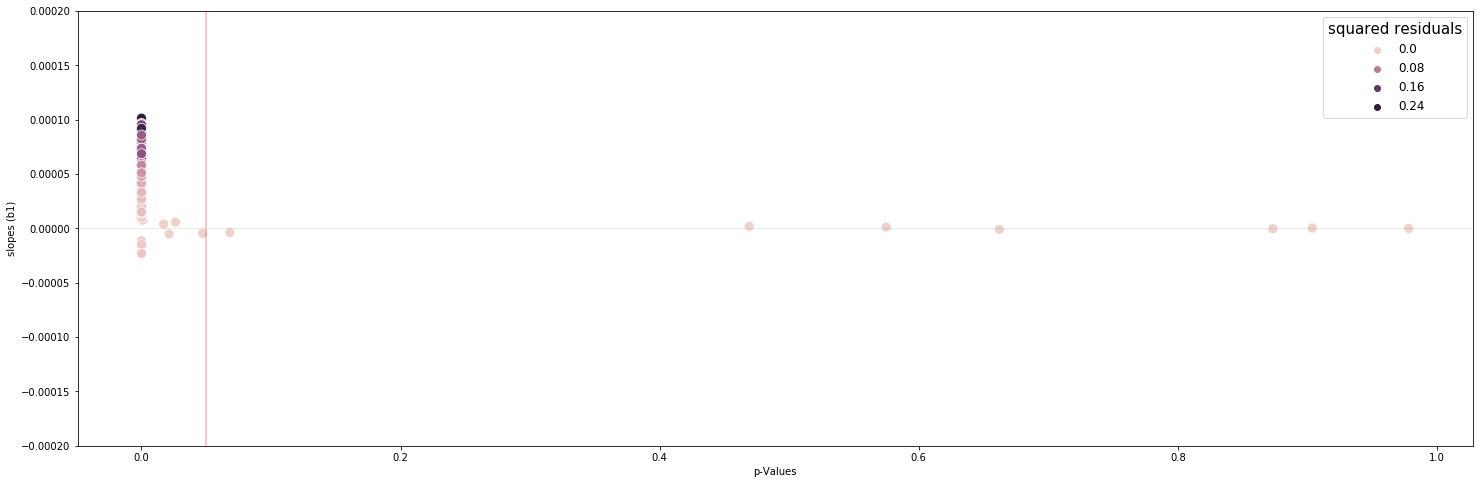

In [55]:
#plotting the slope of the regression line togther with the 

slopes = []
pvals = []
rsq = []

for element in pairs.keys():
    slopes.append(regression[element]["b1"])
    pvals.append(regression[element]["pvalue"][1])
    rsq.append(regression[element]["rsquared"])

plt.figure(figsize = (25,8))
sns.scatterplot(y = slopes, x = pvals, hue = rsq, sizes = 500, s= 100)
plt.legend(title = "squared residuals", fontsize = 12, title_fontsize = 15)
plt.xlabel("p-Values")
plt.ylabel("slopes (b1)")
plt.ylim((-0.0002,0.0002))
#plt.xlim((0,0.055))
plt.axvline(x = 0.05, color = "red", alpha = 0.3)
plt.axhline(y = 0, color = "grey", alpha = 0.3, linewidth = 0.5)

### Auswertung Regressionen
<a id='AuswertungRegression'></a>

Anzahl der Paare 153
Mittelwert b₁: 0.0099
Median b₁: 0.0091


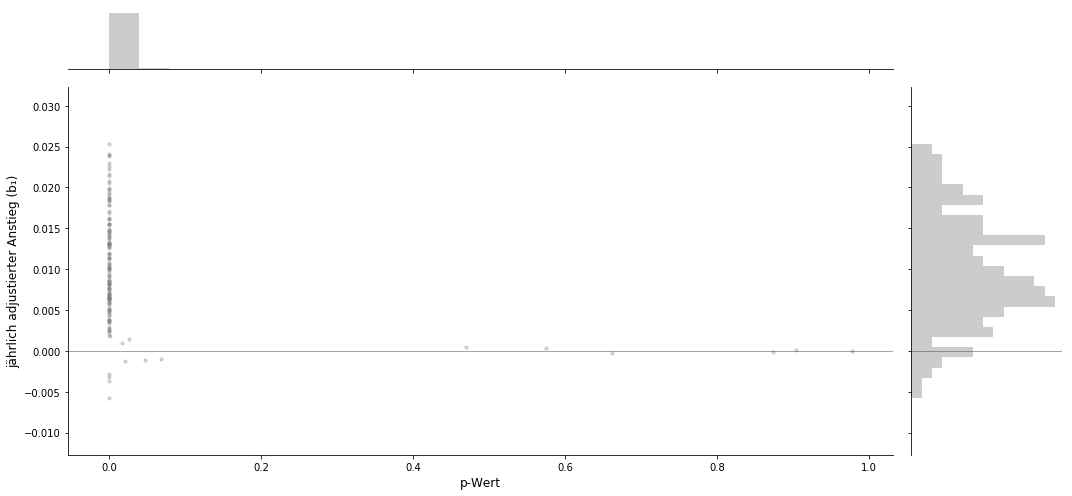

In [56]:
timefactor = 250
adj_slopes = []
for element in slopes:
    adj_slopes.append(element*timefactor)

#use log for better graphic?
#pvals_log = np.log(np.array(pvals))
#pvals_log[np.isneginf(pvals_log)] = 0
    
plot=sns.jointplot(y = adj_slopes, x = pvals,ratio = 5, alpha = 0.3, s = 10, color = "grey", marginal_kws=dict(bins = 25)) #, ylim = (-0.0005,0.0005)
plot.set_axis_labels('p-Wert', 'jährlich adjustierter Anstieg (b\u2081)', fontsize = 12)
plot.fig.set_figwidth(15)
plot.fig.set_figheight(7)

plt.axhline(y=0, color = "red", linewidth = 0.5)
plot.ax_joint.axhline(y=0, color = "red", linewidth = 0.5)

plt.tick_params(labelsize = 12)
plt.tight_layout()

print("Anzahl der Paare", len(adj_slopes))

print("Mittelwert b\u2081:", round(np.mean(adj_slopes),4))
print("Median b\u2081:", round(np.median(adj_slopes),4))

In [57]:
eval_df = pd.DataFrame(
    {'p-Wert': pvals,
     'Anstieg': slopes,
     'R2': rsq,
     "Paar": list(pairs.keys())
    })
eval_df.set_index("Paar", inplace = True)

In [58]:
#Signifikanz der positiven Anstiege testen
df = eval_df[(eval_df["p-Wert"]<0.05)]

sample = np.array(df["Anstieg"].to_list())
#Hypothesentest (t-Test)
#Teststatistik
print("H\u2080: tatsächlicher Mittelwert ist 0")
print("H\u2081: tatsächlicher Mittelwert ist signfikant größer als 0")

n = len(df) #Anzahl der Werte
µ0 = 0 #Mittwelwert der Nullhypothese
µS = df["Anstieg"].mean() #geschätzter Mittelwert
stdS = df["Anstieg"].std() #geschätzte Standardabweichung

alpha = 0.05

T = n**0.5*((µS - µ0)/stdS) #Teststatistik
ttest = sp.stats.ttest_1samp(sample, popmean = 0) #p-Wert muss durch 2 geteilt werden, da es sich um einen einseitigen Test handelt
print("Teststatistik:",ttest[0])
print("p-Wert:", ttest[1]/2, "- Entscheidung: Nullhypothese ablehnen; Mittelwert ist größer als Null")

H₀: tatsächlicher Mittelwert ist 0
H₁: tatsächlicher Mittelwert ist signfikant größer als 0
Teststatistik: 19.485582905133537
p-Wert: 1.2443568344701065e-42 - Entscheidung: Nullhypothese ablehnen; Mittelwert ist größer als Null


In [59]:
#Anzahl der signifikanten, positiven Anstiege
to_print = len(eval_df[(eval_df["p-Wert"]<0.05) & (eval_df["Anstieg"]>0)])/len(eval_df)
print("Anteil signifikante, positive Anstiege (0.05): {}%".format(str(round(to_print,4)*100)))

to_print = len(eval_df[(eval_df["p-Wert"]<0.01) & (eval_df["Anstieg"]>0)])/len(eval_df)
print("Anteil signifikante, positive Anstiege (0.01): {}%".format(str(round(to_print,4)*100)))

to_print = len(eval_df[(eval_df["p-Wert"]<0.05)])/len(eval_df)
print("Anteil signifikante Anstiege (0.05): {}%".format(str(round(to_print,4)*100)))

to_print = len(eval_df[(eval_df["p-Wert"]<0.01)])/len(eval_df)
print("Anteil signifikante Anstiege (0.01): {}%".format(str(round(to_print,4)*100)))

to_print = len(eval_df[(eval_df["Anstieg"]>0)])/len(eval_df)
print("Anteil positive Anstiege: {}%".format(str(round(to_print,4)*100)))
to_print = len(eval_df[(eval_df["Anstieg"]>0)])
print("Anzahl positive Anstiege: {}".format(str(round(to_print,4))))

to_print = len(eval_df[(eval_df["Anstieg"]>0) & (eval_df["p-Wert"]<0.05)])/len(eval_df[(eval_df["p-Wert"]<0.05)])
print("Anteil positive Anstiege unter signifikanten Werten: {}%".format(str(round(to_print,4)*100)))

Anteil signifikante, positive Anstiege (0.05): 91.5%
Anteil signifikante, positive Anstiege (0.01): 90.2%
Anteil signifikante Anstiege (0.05): 95.42%
Anteil signifikante Anstiege (0.01): 92.81%
Anteil positive Anstiege: 93.46%
Anzahl positive Anstiege: 143
Anteil positive Anstiege unter signifikanten Werten: 95.89%


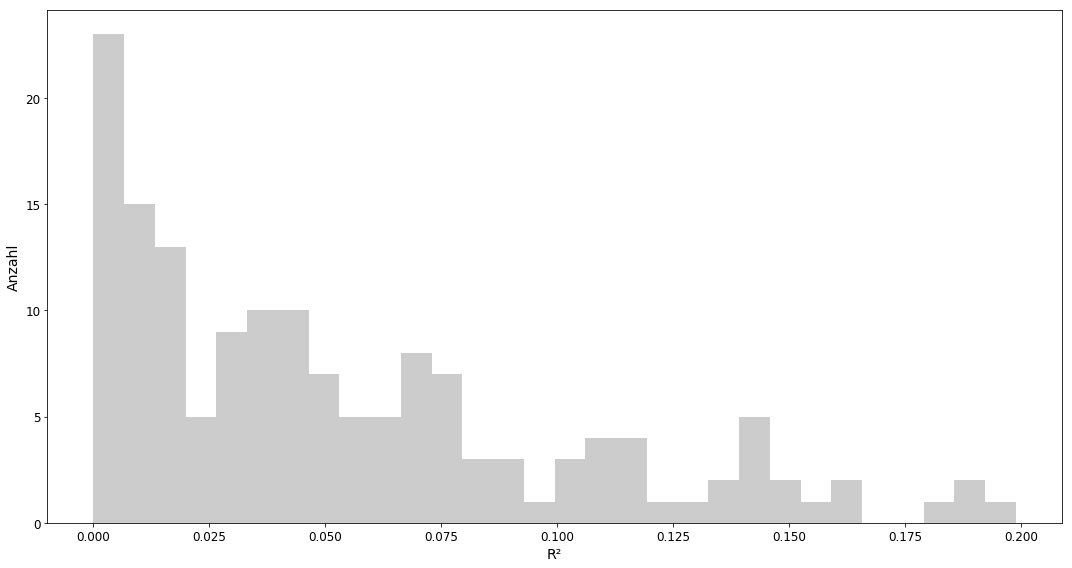

In [60]:
#R-Quadrate
plt.figure(figsize = (15,8))
sns.distplot(rsq, hist = True, kde = False, color = "grey", norm_hist = False, bins = 30)
plt.xlabel("R\u00b2", fontsize = 14) 
plt.ylabel('Anzahl', fontsize = 14)
plt.title("Verteilung R² der OLS-Regressionsgeraden der gleitenden Korrelation ", fontsize = 14)

plt.tick_params(labelsize = 12)
plt.tight_layout()

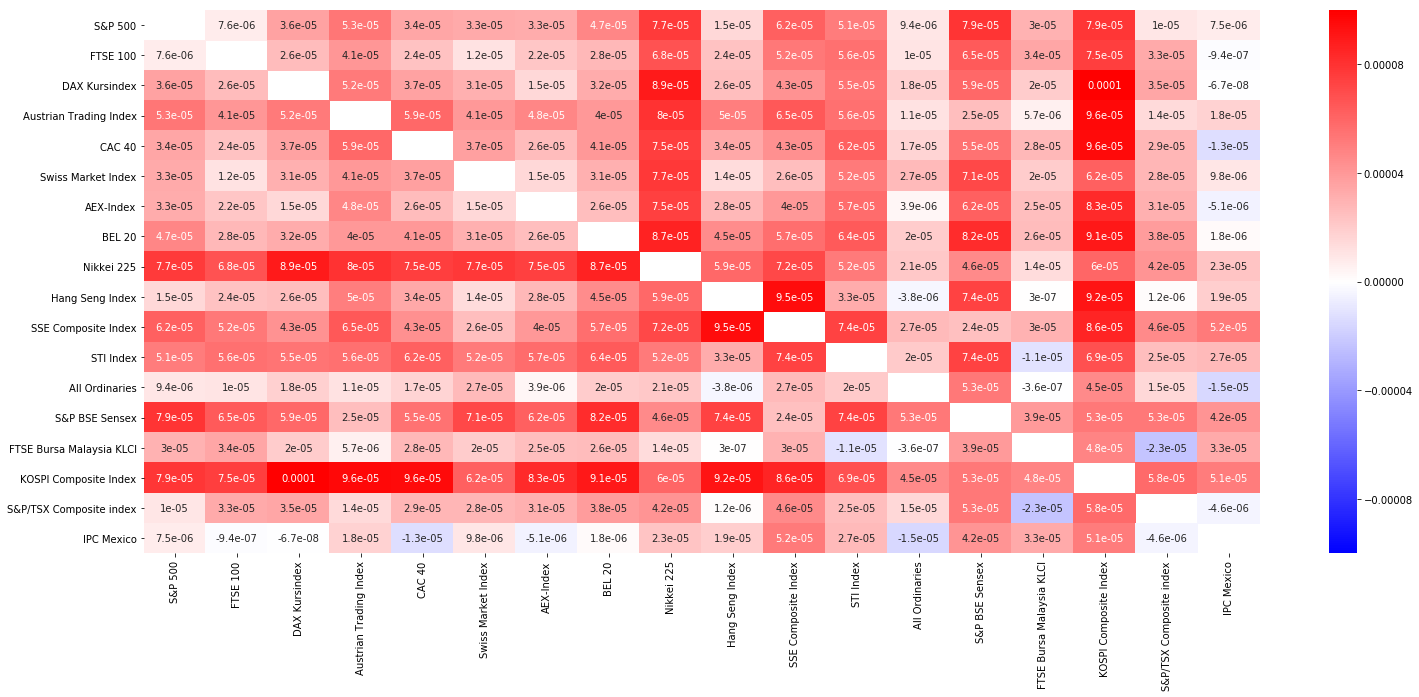

In [61]:
slope_matrix = pd.DataFrame(columns = symbols, index = symbols)

n = 0
for element in pairs.keys():
    first = element[:element.find(" ")]
    second = element[element.find(" ")+3:]
    slope_matrix.loc[first,second]=float(regression[element]["b1"])
    slope_matrix.loc[second,first]=float(regression[element]["b1"])
    n+=1
slope_matrix.fillna(1, inplace = True)
slope_matrix.columns = index_names
slope_matrix.index = index_names

f, ax = plt.subplots(figsize=(25, 10))
#sns.heatmap(slopes)
sns.heatmap(slope_matrix, annot = True, cmap = "bwr", mask = slope_matrix > 0.9999999, vmin = -0.0001, vmax = 0.0001)
plt.title("Anstieg der OLS-Regressionen der gleitenden Korrelation jedes Indexpaares (ohne zeitliche Anpassung)", fontsize = 14)

In [62]:
greater_zero = 0
for element in slopes:
    if (element > 0 and pvals[slopes.index(element)]<0.05):
        greater_zero += 1
print("Anzahl signifikanter positiver Anstiege:", greater_zero)

Anzahl signifikanter positiver Anstiege: 140


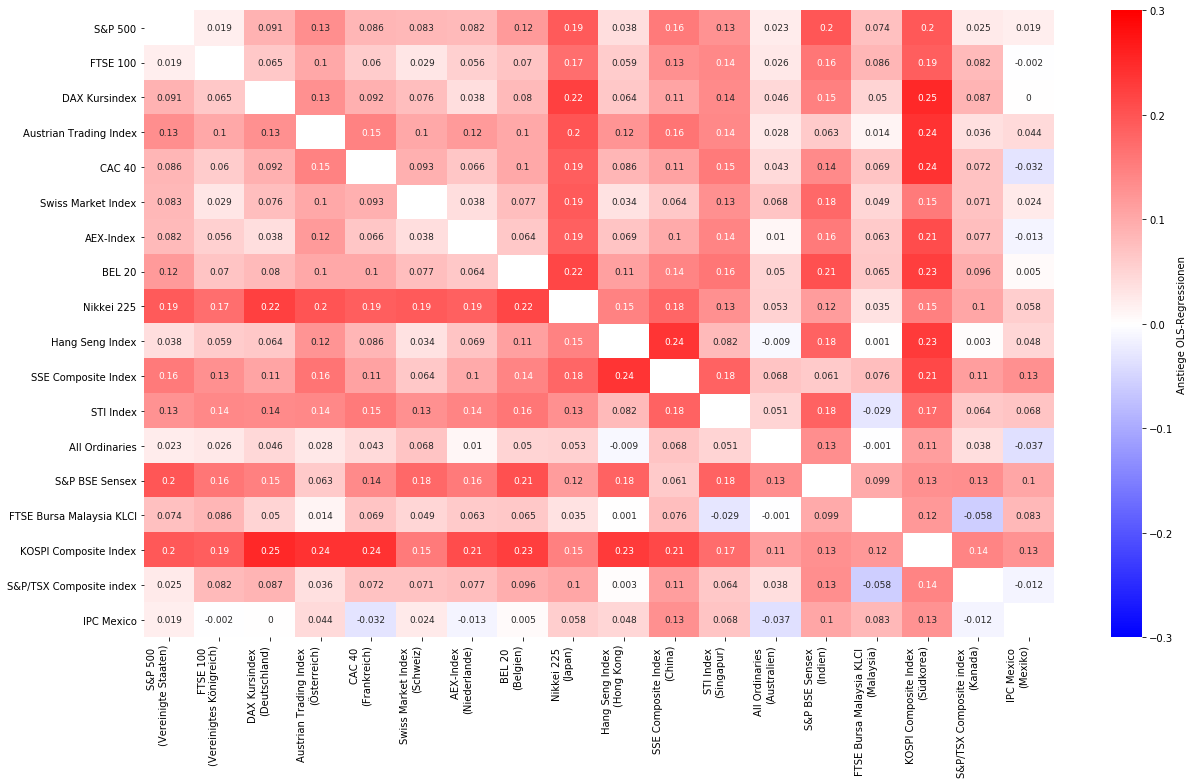

In [63]:
#correct matrix to see the effect over years instead of days

years = 10
days = 250 * years
adj_slopes = []

slope_matrix = pd.DataFrame(columns = symbols, index = symbols)

n = 0
for element in pairs.keys():
    first = element[:element.find(" ")]
    second = element[element.find(" ")+3:]
    slope_matrix.loc[first,second]=float(regression[element]["b1"])*days
    slope_matrix.loc[second,first]=float(regression[element]["b1"])*days
    adj_slopes.append(float(regression[element]["b1"])*days)
    n+=1

index_names_country = []

for element in index_names:
    temp = element + " \n" + "(" + translate_countries(name_to_country[element]) + ")"
    index_names_country.append(temp)    

slope_matrix.fillna(1, inplace = True)
slope_matrix.columns = index_names_country
slope_matrix.index = index_names
slope_matrix = slope_matrix.round(3).replace(1,np.nan).replace(-0.000,0)


f, ax = plt.subplots(figsize=(18, 11)) # vorher 15,8
#sns.heatmap(slopes)
sns.heatmap(slope_matrix, annot = True, cmap = "bwr", mask = slope_matrix > 0.9999999, 
            vmin = -0.3, vmax = 0.3, annot_kws={"fontsize":9}, cbar_kws={'label': 'Anstiege OLS-Regressionen'})
#sns.heatmap(slope_matrix, annot = False, cmap = "Greys", mask = slope_matrix !=1, cbar = False, vmin = 0.7, vmax = 1.7)
plt.title("Anstieg der OLS-Regressionen der gleitenden Korrelation jedes Indexpaares (adjustiert an einen Zeitraum von 10 Jahren)", fontsize = 20)
plt.xticks(ha = "right")

plt.tight_layout()

In [65]:
slopes = np.array(adj_slopes)

slope_summary = slope_matrix.describe().T
slope_summary.index = slope_matrix.index
slope_summary.loc["Insgesamt","count"]= len(slopes)
slope_summary.loc["Insgesamt","mean"]= np.mean(slopes)
slope_summary.loc["Insgesamt","std"]= np.std(slopes)
slope_summary.loc["Insgesamt","min"]= min(slopes)
slope_summary.loc["Insgesamt","max"]= max(slopes)
slope_summary.loc["Insgesamt","25%"]= np.percentile(slopes, 25)
slope_summary.loc["Insgesamt","50%"]= np.percentile(slopes, 50)
slope_summary.loc["Insgesamt","75%"]= np.percentile(slopes, 75)
slope_summary.rename(columns = {"count":"Anzahl","mean":"µ","std":"\u03C3"}, inplace = True)

slope_summary = slope_summary.round(3)
print("Auswertung der OLS-Regressionsanstiege (10 Jahre adjustiert) gruppiert nach Indizes")
display(slope_summary)
print("*Korrelationen mit eigenem Index wurden vernachlässigt")
print("**bezieht sich lediglich auf individuelle Länderpaare")

,Anzahl,µ,σ,min,25%,50%,75%,max
S&P 500,17.0,0.098,0.063,0.019,0.038,0.086,0.133,0.198
FTSE 100,17.0,0.085,0.056,-0.002,0.056,0.070,0.131,0.188
DAX Kursindex,17.0,0.099,0.064,0.000,0.064,0.087,0.131,0.253
Austrian Trading Index,17.0,0.111,0.061,0.014,0.063,0.119,0.140,0.241
CAC 40,17.0,0.101,0.061,-0.032,0.069,0.092,0.138,0.240
Swiss Market Index,17.0,0.086,0.051,0.024,0.049,0.076,0.101,0.194
AEX-Index,17.0,0.086,0.060,-0.013,0.056,0.069,0.119,0.209
BEL 20,17.0,0.111,0.062,0.005,0.070,0.101,0.143,0.226
Nikkei 225,17.0,0.150,0.059,0.035,0.115,0.169,0.193,0.223
Hang Seng Index,17.0,0.089,0.075,-0.009,0.038,0.069,0.125,0.238


*Korrelationen mit eigenem Index wurden vernachlässigt
**bezieht sich lediglich auf individuelle Länderpaare


In [66]:
number_developed = list(country_classification.values()).count("Developed")
number_emerging = list(country_classification.values()).count("Emerging")

#testen, ob ein Zusammenhang mit dem Entwicklungsstatus besteht
temp = pd.DataFrame.from_dict(country_classification, orient = "index").rename(columns = {0:"Klassifizierung"})
temp.index = slope_summary.index[:-1]
#temp.index = translate_countries(temp.index.to_list())
slope_summary = slope_summary.join(temp).groupby(by = "Klassifizierung").mean()
slope_summary.loc["Developed","Anzahl"] = int(number_developed)
slope_summary.loc["Emerging","Anzahl"] = int(number_emerging)
slope_summary = slope_summary.round(3)
print("Auswertung der Regressionsanstiege (10 Jahre adjustiert) gruppiert nach Länderklassifizierung")
display(slope_summary)

,Anzahl,µ,σ,min,25%,50%,75%,max
Klassifizierung,,,,,,,,
Developed,13.0,0.095,0.059,-0.006,0.058,0.091,0.128,0.205
Emerging,5.0,0.108,0.049,0.028,0.074,0.109,0.142,0.189


In [67]:
development_classification = pd.DataFrame.from_dict(country_classification, orient = "index").rename(columns = {0:"Klassifizierung"})
development_classification.index = translate_countries(development_classification.index.to_list())
print("Länderklassifizierungen")
display(development_classification)

,Klassifizierung
Vereinigte Staaten,Developed
Vereinigtes Königreich,Developed
Deutschland,Developed
Österreich,Developed
Frankreich,Developed
Schweiz,Developed
Niederlande,Developed
Belgien,Developed
Japan,Developed
Hong Kong,Developed


In [68]:
#Verteilungsfunktion

np_adj_slopes = np.array(adj_slopes)
slopes_max = np.max(np_adj_slopes)
slopes_min = np.min(np_adj_slopes)
step = (slopes_max - slopes_min)/1000
n = len(np_adj_slopes)

#kummulierte Summe
steps = [slopes_min]
for element in np.array([step]*1000):
    new_step = steps[-1]+element
    steps.append(new_step)

#Anteile berechnen
percentages = []
for step in steps:
    percentages.append(len(np.where(np_adj_slopes < step)[0])/n)

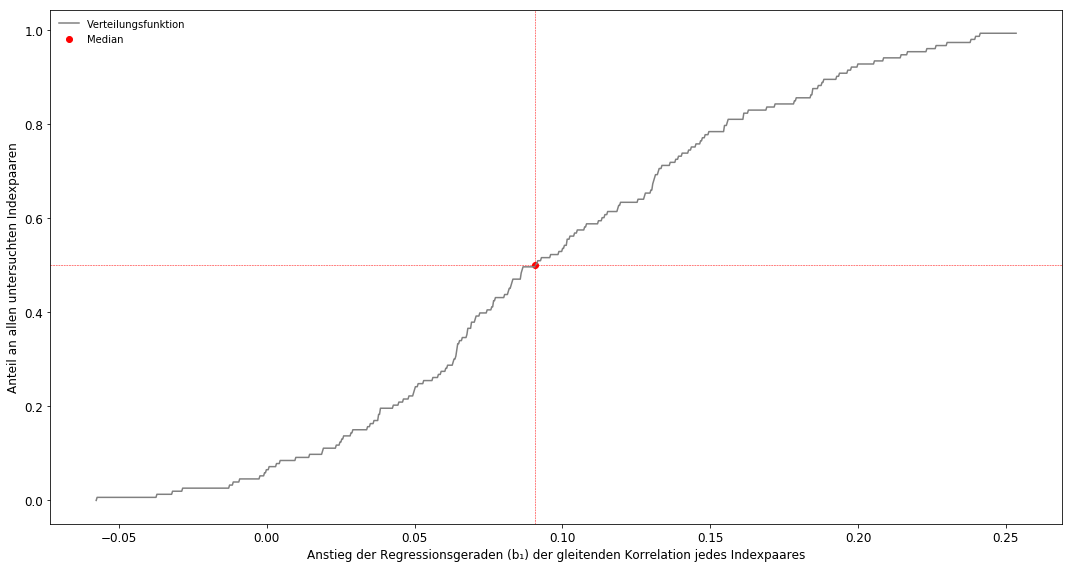

In [69]:
plt.figure(figsize = (15,8))
plt.plot(steps, percentages, color = "grey", label = "Verteilungsfunktion")
plt.axvline(x = np.median(np_adj_slopes), color = "red", linewidth = 0.5, linestyle = '--')
plt.axhline(y = 0.5, color = "red", linewidth = 0.5, linestyle = '--')
plt.xlabel("Anstieg der Regressionsgeraden (b\u2081) der gleitenden Korrelation jedes Indexpaares", fontsize = 12)
plt.ylabel("Anteil an allen untersuchten Indexpaaren", fontsize = 12)
plt.tick_params(axis='both', labelsize=12)

plt.scatter(x = np.median(np_adj_slopes), y = 0.5, color = "red", label = "Median")

plt.legend(frameon = False)
plt.title("Verteilungsfunktion für die Anstiege", fontsize = 14)

plt.tight_layout()

In [70]:
name_and_country = []
for element in index_names:
    name_and_country.append("{} ({})".format(element, name_to_country[element]))

In [72]:
anstiegs_df = pd.DataFrame.from_dict(dict(zip(pairs.keys(),adj_slopes)), orient = "index").rename(columns = {0:"Anstieg"})
anstiegs_df["CountryClassification"] = 0

for element in anstiegs_df.index:
    first = element[:element.find(" ")]
    second = element[element.find(" ")+3:]
    
    #translate to countries
    country1 = symbol_to_country[first]  
    country2 = symbol_to_country[second]
    
    if country_classification[country1] == country_classification[country2]:
        anstiegs_df.loc[element,"CountryClassification"] = country_classification[country1]
    else:
        anstiegs_df.loc[element,"CountryClassification"] = "Developed & Emerging"

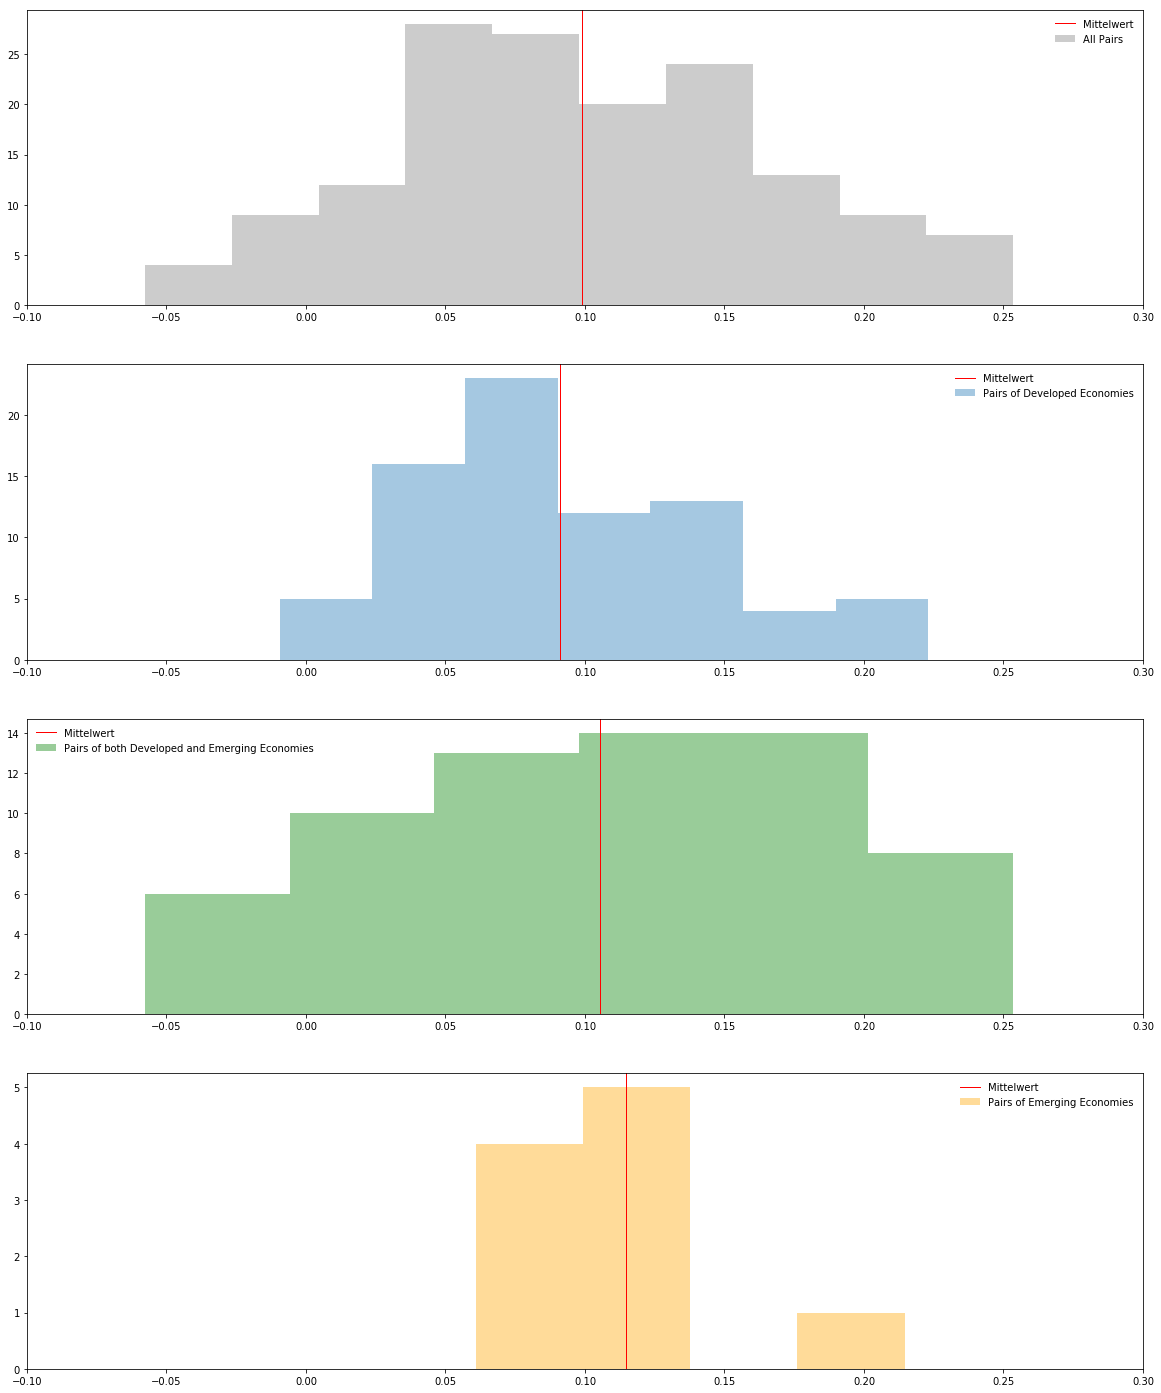

In [73]:
plt.figure(figsize = (20,25))
plt.subplot(4,1,1)
sns.distplot(anstiegs_df["Anstieg"].to_numpy(), kde = False, color = "grey", label = "All Pairs")
plt.axvline(x = np.mean(anstiegs_df["Anstieg"]), 
            color = "red", label = "Mittelwert", linewidth = 1)
plt.xlim(-0.1,0.3)
plt.legend(frameon = False)

plt.subplot(4,1,2)
sns.distplot(anstiegs_df[anstiegs_df["CountryClassification"] == "Developed"]["Anstieg"].to_numpy(), 
             kde = False, label = "Pairs of Developed Economies")
plt.axvline(x = np.mean(anstiegs_df[anstiegs_df["CountryClassification"] == "Developed"]["Anstieg"]), 
            color = "red", label = "Mittelwert", linewidth = 1)
plt.xlim(-0.1,0.3)
plt.legend(frameon = False)

plt.subplot(4,1,3)
sns.distplot(anstiegs_df[anstiegs_df["CountryClassification"] == "Developed & Emerging"]["Anstieg"].to_numpy(), 
             kde = False, color = "green", label = "Pairs of both Developed and Emerging Economies")
plt.axvline(x = np.mean(anstiegs_df[anstiegs_df["CountryClassification"] == "Developed & Emerging"]["Anstieg"]), 
            color = "red", label = "Mittelwert", linewidth = 1)
plt.xlim(-0.1,0.3)
plt.legend(frameon = False)

plt.subplot(4,1,4)
sns.distplot(anstiegs_df[anstiegs_df["CountryClassification"] == "Emerging"]["Anstieg"].to_numpy(), 
             kde = False, color = "orange", label = "Pairs of Emerging Economies")
plt.axvline(x = np.mean(anstiegs_df[anstiegs_df["CountryClassification"] == "Emerging"]["Anstieg"]), 
            color = "red", label = "Mittelwert", linewidth = 1)
plt.xlim(-0.1,0.3)
plt.legend(frameon = False)

In [75]:
start_day = "1992-01-07"
end_day = "2020-04-01"
classification_dfs = {}
classification_pairs = ["Developed - Developed", "Developed - Emerging","Emerging - Emerging" ]
pair_counts = {}

for element in classification_pairs:
    classification_dfs[element] = pd.DataFrame(index = pd.date_range(start=start_day,end=end_day))
    classification_dfs[element].index.name = 'date'
    pair_counts[element] = 0

#dataframe für alle
temp = pd.DataFrame(index = pd.date_range(start=start_day,end=end_day))

for element in pairs.keys():
    first = element[:element.find(" ")]
    second = element[element.find(" ")+3:]
    
    #translate to countries
    country1 = symbol_to_country[first]    
    country2 = symbol_to_country[second]
    
    if country_classification[country1] == "Developed" and country_classification[country2] == "Developed":
        classification_dfs["Developed - Developed"] = classification_dfs["Developed - Developed"].join(pd.DataFrame(pairs[element]).rename(columns = {0:element}))
        pair_counts["Developed - Developed"] += 1
        
    elif country_classification[country1] == "Developed" and country_classification[country2] == "Emerging":
        classification_dfs["Developed - Emerging"] = classification_dfs["Developed - Emerging"].join(pd.DataFrame(pairs[element]).rename(columns = {0:element}))
        pair_counts["Developed - Emerging"] += 1
        
    elif country_classification[country1] == "Emerging" and country_classification[country2] == "Developed":
        classification_dfs["Developed - Emerging"] = classification_dfs["Developed - Emerging"].join(pd.DataFrame(pairs[element]).rename(columns = {0:element}))
        pair_counts["Developed - Emerging"] += 1
        
    elif country_classification[country1] == "Emerging" and country_classification[country2] == "Emerging":
        classification_dfs["Emerging - Emerging"] = classification_dfs["Emerging - Emerging"].join(pd.DataFrame(pairs[element]).rename(columns = {0:element}))  
        pair_counts["Emerging - Emerging"] += 1
    
    #zu dataframe für alle Länderpaare hinzufügen
    temp = temp.join(pd.DataFrame(pairs[element]).rename(columns = {0:element}))
    
classification_dfs["Alle Länderpaare"] = temp       
means = pd.DataFrame(index = pd.date_range(start="1992-04-07",end=end_day))

for element in classification_dfs.keys():
    classification_dfs[element] = classification_dfs[element].loc["1992-04-07":].dropna(how = "all").fillna(method = "ffill").fillna(method = "bfill")
    classification_dfs[element]["Mean"] = classification_dfs[element].mean(axis=1)
    means = means.join(classification_dfs[element]["Mean"]).rename(columns = {"Mean":element})
    
means = means.dropna(how = "all").fillna(method = "ffill")

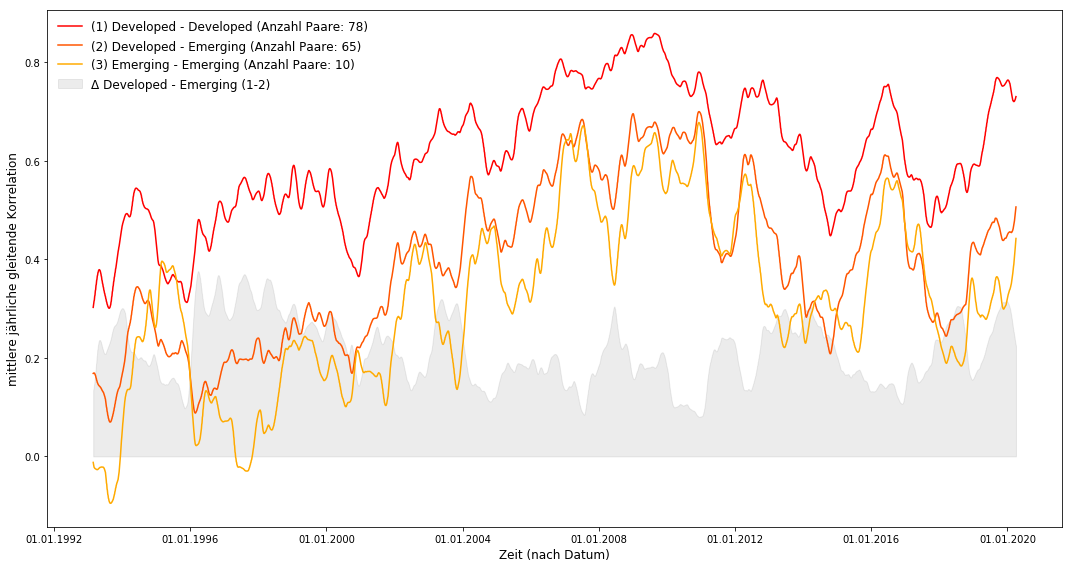

In [76]:
cmap = matplotlib.cm.autumn

plt.figure(figsize = (15,8))
for i, element in enumerate(classification_pairs):
    plt.plot(means[element].rolling(window = 250).mean(), label = "({}) ".format(i+1) + element + " (Anzahl Paare: " +str(pair_counts[element])+")", color = cmap(i/len(classification_pairs)))

plt.fill_between(x = means.index, y1 = means["Developed - Developed"].rolling(window = 250).mean()-means["Developed - Emerging"].rolling(window = 250).mean(), color = "grey", alpha = 0.15, label = "\u0394 Developed - Emerging (1-2)")
plt.legend(frameon = False, fontsize = 12)
plt.xlabel("Zeit (nach Datum)", fontsize = 12)
plt.ylabel("mittlere jährliche gleitende Korrelation", fontsize = 12)
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d.%m.%Y'))
plt.title("zeitliche Entwicklung der Mittel der nach Länderklassifizierung gruppierten gleitenden Korrelationen (Fenster = 1 Jahr)", fontsize = 14)

plt.tight_layout()

In [77]:
for element in classification_pairs:
    print("Arithmetisches Mittel",element,":",round(np.mean(means[element]),2))

Arithmetisches Mittel Developed - Developed : 0.61
Arithmetisches Mittel Developed - Emerging : 0.39
Arithmetisches Mittel Emerging - Emerging : 0.32


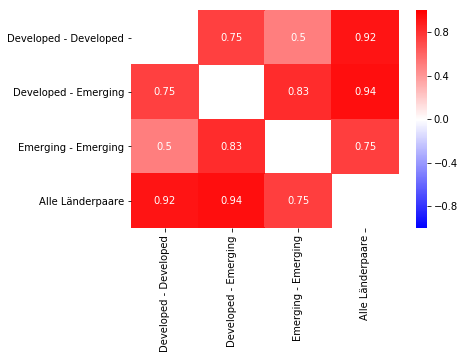

In [78]:
sns.heatmap(means.corr(), cmap = "bwr", vmin = -1, vmax = 1, annot = True, mask = means.corr() > 1-0.000001)

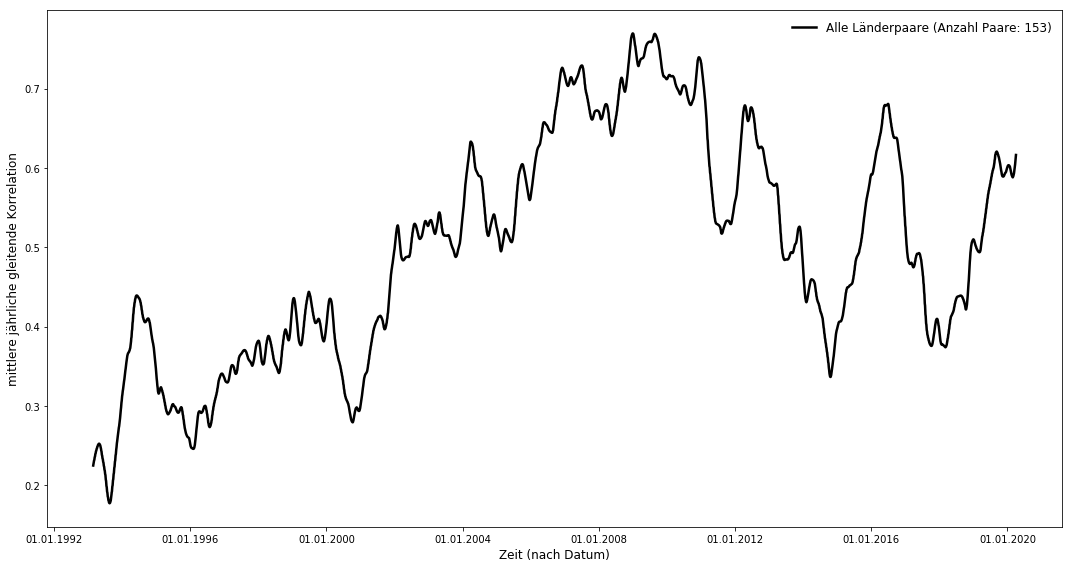

In [79]:
plt.figure(figsize = (15,8))

# for i, element in enumerate(classification_pairs):
#     plt.plot(means[element].rolling(window = 250).mean(), 
#              label = "({}) ".format(i+1) + element + " (Anzahl Paare: " +str(pair_counts[element])+")", 
#              color = cmap(i/len(classification_pairs)),
#             alpha = 0.5)

plt.plot(means["Alle Länderpaare"].rolling(window = 250).mean(), 
         label = "Alle Länderpaare" + " (Anzahl Paare: " +str(anzahl)+")", 
         color = "black", 
        linewidth = 2.5)

plt.legend(frameon = False, fontsize = 12)
plt.xlabel("Zeit (nach Datum)", fontsize = 12)
plt.ylabel("mittlere jährliche gleitende Korrelation", fontsize = 12)
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d.%m.%Y'))
plt.title("zeitliche Entwicklung der Mittel der gleitenden Korrelationen (Fenster = 1 Jahr) aller Länderpaare", fontsize = 14)

plt.tight_layout()

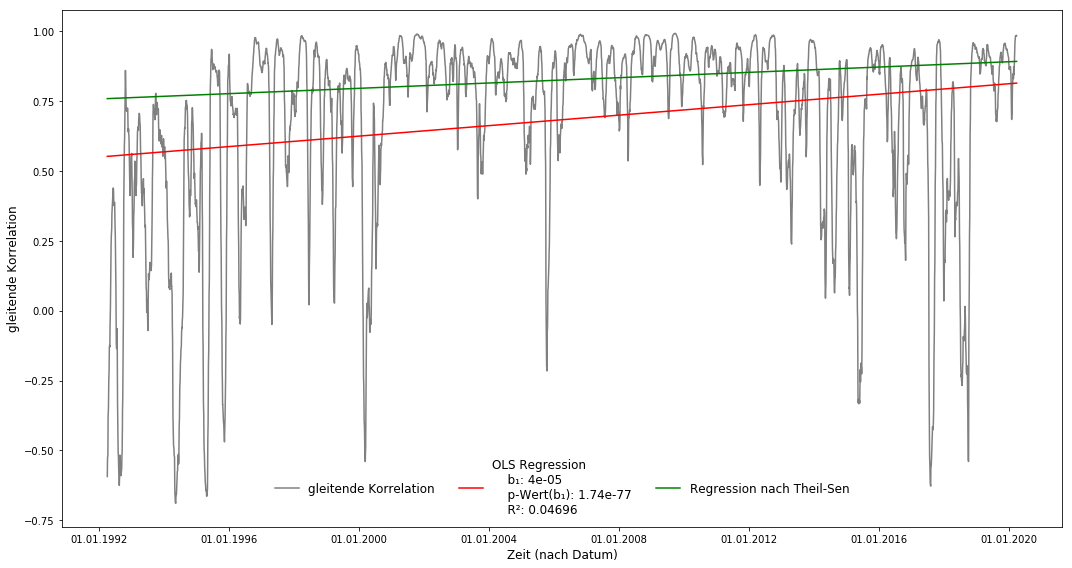

In [80]:
pair = "^GSPC + ^GDAXIP"

test_data = pairs[pair].to_numpy()
test_data = test_data[~np.isnan(test_data)]
days = np.arange(1,len(test_data)+1)
test_df = pd.DataFrame.from_dict(dict(zip(days,test_data)), orient = "index").rename(columns = {0:"Gleitende Korrelation"})
test_df["Timestamps"]=pairs[pair][window-1:].index.to_list()
test_df = test_df.reset_index().rename(columns = {"index":"Day"})

#calculate Theil-Sen-Slope
theilsen = sp.stats.mstats.theilslopes(test_data, days)
theil_slope = theilsen[0]
theil_intercept = theilsen[1]

#add to dataframe
test_df["Theil_Regression"] = theil_slope * test_df["Day"] + theil_intercept

#compare ordinary least squares (OLS)
test_df["OLS_Regression"] = regression[pair]["predicted"]

test_df.set_index("Timestamps", inplace = True)
    
    
plt.figure(figsize = (15,8))
plt.plot(test_df["Gleitende Korrelation"], color = "grey", label = "gleitende Korrelation")

plt.plot(test_df["OLS_Regression"], color = "red", label = "OLS Regression\n    b\u2081: {}\n    p-Wert(b\u2081): {}\n    R\u00b2: {}".format(round(regression[pair]["b1"],5),
                                                                                                1.74e-77,
                                                                                                round(regression[pair]["rsquared"],5)))
plt.plot(test_df["Theil_Regression"], color = "green", label = "Regression nach Theil-Sen")

plt.xlabel("Zeit (nach Datum)", fontsize = 12)
plt.ylabel("gleitende Korrelation", fontsize = 12)
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d.%m.%Y'))
plt.legend(loc = 'lower center', fontsize = 12, frameon = False, ncol = 3)
plt.title("Darstellung der gleitenden Korrelation und der Regression", fontsize = 14)
plt.tight_layout()

In [81]:
calculate_new = False

if calculate_new == True:
    
    theil_regression = {}
    for pair in tqdm(pairs.keys()):
        #pair = "^GSPC + ^GDAXIP"
        theil_regression[pair]={}

        test_data = pairs[pair].to_numpy()
        test_data = test_data[~np.isnan(test_data)]
        days = np.arange(1,len(test_data)+1)
        test_df = pd.DataFrame.from_dict(dict(zip(days,test_data)), orient = "index").rename(columns = {0:"Gleitende Korrelation"})
        test_df["Timestamps"]=pairs[pair][window-1:].index.to_list()
        test_df = test_df.reset_index().rename(columns = {"index":"Day"})

        #calculate Theil-Sen-Slope
        theilsen = sp.stats.mstats.theilslopes(test_data, days)
        theil_slope = theilsen[0]
        theil_intercept = theilsen[1]

        #add to dataframe
        test_df["Theil_Regression"] = theil_slope * test_df["Day"] + theil_intercept

        #compare ordinary least squares (OLS)
        test_df["OLS_Regression"] = regression[pair]["predicted"]

        test_df.set_index("Timestamps", inplace = True)

        theil_regression[pair]["dataframe"]=test_df
        theil_regression[pair]["slope"] = theil_slope
        theil_regression[pair]["intercept"] = theil_intercept

        theil_df = pd.DataFrame(index = theil_regression.keys(), columns = ["slope","adj_slope","intercept"])
        for pair in theil_regression.keys():
            theil_df.loc[pair,"slope"]=theil_regression[pair]["slope"]
            theil_df.loc[pair,"intercept"]=theil_regression[pair]["intercept"]
            theil_df.loc[pair,"adj_slope"]=theil_regression[pair]["slope"]*250*10
        
else:
    theil_df = pd.read_csv("Data/Theil_Sen_Regression/slope_intercept.csv")
    theil_df = theil_df.rename(columns = {theil_df.columns[0]:"Indexpaar"}).set_index("Indexpaar")

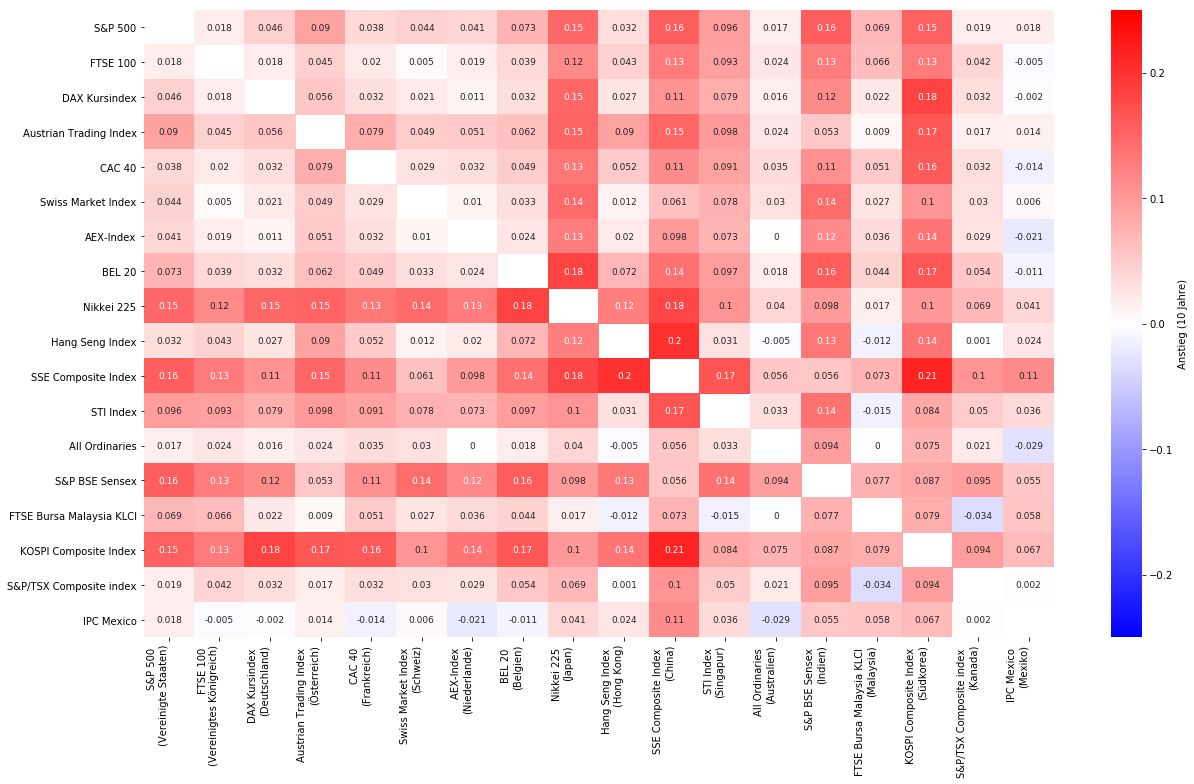

In [82]:
theil_matrix = pd.DataFrame(columns = symbols, index = symbols)

for element in theil_df.index:
    first = element[:element.find(" ")]
    second = element[element.find(" ")+3:]
    theil_matrix.loc[first,second]=float(theil_df.loc[element,"adj_slope"])
    theil_matrix.loc[second,first]=float(theil_df.loc[element,"adj_slope"])
theil_matrix.fillna(1, inplace = True)
theil_matrix.columns = index_names_country
theil_matrix.index = index_names
theil_matrix.replace(1,np.nan, inplace = True)

plt.figure(figsize=(18, 11)) #vorher 15,8
#sns.heatmap(slopes)
sns.heatmap(theil_matrix.round(3), annot = True, cmap = "bwr", mask = theil_matrix > 0.9999999, 
            vmin = -0.25, vmax = 0.25, cbar_kws={'label': 'Anstieg (10 Jahre)'}, annot_kws={"fontsize":9})
#sns.heatmap(slope_matrix, annot = False, cmap = "Greys", mask = slope_matrix !=1, cbar = False, vmin = 0.7, vmax = 1.7)
plt.xticks(ha = "right")
plt.title("Anstiege der Theil-Sen-Regressionen der gleitenden Korrelation jedes Indexpaares (adjustiert an einen Zeitraum von 10 Jahren) ")
plt.tight_layout()

In [83]:
slopes = theil_df["adj_slope"].to_numpy()

slope_summary_ts = theil_matrix.describe().T
slope_summary_ts.index = theil_matrix.index
slope_summary_ts.loc["Insgesamt","count"]= len(slopes)
slope_summary_ts.loc["Insgesamt","mean"]= np.mean(slopes)
slope_summary_ts.loc["Insgesamt","std"]= np.std(slopes)
slope_summary_ts.loc["Insgesamt","min"]= min(slopes)
slope_summary_ts.loc["Insgesamt","max"]= max(slopes)
slope_summary_ts.loc["Insgesamt","25%"]= np.percentile(slopes, 25)
slope_summary_ts.loc["Insgesamt","50%"]= np.percentile(slopes, 50)
slope_summary_ts.loc["Insgesamt","75%"]= np.percentile(slopes, 75)
slope_summary_ts.rename(columns = {"count":"Anzahl","mean":"µ","std":"\u03C3"}, inplace = True)

slope_summary_ts = slope_summary_ts.round(3)
print("Theil-Sen-Regressionsanstiege (10 Jahre adjustiert) gruppiert nach Indizes")
display(slope_summary_ts)
print("*Korrelationen mit eigenem Index wurden vernachlässigt")
print("**bezieht sich lediglich auf individuelle Länderpaare")

,Anzahl,µ,σ,min,25%,50%,75%,max
S&P 500,17.0,0.072,0.053,0.017,0.032,0.046,0.096,0.157
FTSE 100,17.0,0.055,0.046,-0.005,0.019,0.042,0.093,0.129
DAX Kursindex,17.0,0.056,0.053,-0.002,0.021,0.032,0.079,0.185
Austrian Trading Index,17.0,0.071,0.049,0.009,0.045,0.056,0.090,0.166
CAC 40,17.0,0.061,0.046,-0.014,0.032,0.049,0.091,0.161
Swiss Market Index,17.0,0.049,0.044,0.005,0.021,0.030,0.061,0.145
AEX-Index,17.0,0.047,0.047,-0.021,0.019,0.032,0.073,0.136
BEL 20,17.0,0.073,0.057,-0.011,0.033,0.054,0.097,0.184
Nikkei 225,17.0,0.113,0.048,0.017,0.098,0.125,0.148,0.184
Hang Seng Index,17.0,0.058,0.060,-0.012,0.020,0.032,0.090,0.203


*Korrelationen mit eigenem Index wurden vernachlässigt
**bezieht sich lediglich auf individuelle Länderpaare


In [84]:
print("Anteil positiv nach Theil-Sen:", len(slopes[slopes > 0])/len(slopes))
print("Anzahl positiv nach Theil-Sen:", len(slopes[slopes > 0]))      

Anteil positiv nach Theil-Sen: 0.934640522875817
Anzahl positiv nach Theil-Sen: 143


In [ ]:
temp = pd.DataFrame.from_dict(country_classification, orient = "index").rename(columns = {0:"Klassifizierung"})
temp.index = slope_summary_ts.index[:-1]
#temp.index = translate_countries(temp.index.to_list())
slope_summary_ts = slope_summary_ts.join(temp).groupby(by = "Klassifizierung").mean()
slope_summary_ts.loc["Developed","Anzahl"] = int(number_developed)
slope_summary_ts.loc["Emerging","Anzahl"] = int(number_emerging)
slope_summary_ts = slope_summary_ts.round(3)
print("Auswertung der Regressionsanstiege (10 Jahre adjustiert) gruppiert nach Länderklassifizierung")
display(slope_summary_ts)

## 2. Analyse der Handelsdaten
<a id='AnalyseHandelsdaten'></a>

### 2.1. Vorbereitung der Daten
<a id='VorbereitungDatenHandel'></a>

Data from: https://wits.worldbank.org

In [86]:
#dictionary for country name translation
country_translation = {'United States': 'USA',
 'Italy': 'Italy',
 'Russian Federation': 'Russia',
 'United Kingdom': 'UK',
 'Germany': 'Germany',
 'Austria':'Austria',
 'Switzerland':'Switzerland',                      
 'Spain':'Spain',
 'France': 'France',
 'Belgium': 'Belgium',
 'Netherlands':'Netherlands',                      
 'Japan': 'Japan',
 'Hong Kong, China': 'HongKong',
 'China': 'China',
 'Singapore': 'Singapore',
 'Australia': 'Australia',
 'India': 'India',
 'Indonesia': 'Indonesia',
 'Malaysia': 'Malaysia',
 'Korea, Rep.': 'SouthKorea',
 'Canada': 'Canada',
 'Mexico': 'Mexico',
 'Argentina': 'Argentina',
 'Israel': 'Israel',
 'Egypt': 'Egypt',
 'South Africa': 'SouthAfrica'}

In [87]:
#importing trade data from csv

imports = {}
sheet_name = "Partner-Timeseries"

removed_countries_trade = []

for country in countries:
    try:
        imports[country] = pd.read_excel("Data/Trade/Imports/{}import.xlsx".format(country), sheet_name = 1)
        imports[country] = imports[country].drop(["Reporter Name","Trade Flow","Product Group","Indicator"], axis = 1) #drop not needed columns
        imports[country].set_index("Partner Name", inplace = True)
        
        #adapt country names
        for element in country_translation.keys():
            for row in imports[country].index:
                if row == element:
                    as_list = imports[country].index.tolist()
                    idx = as_list.index(row)
                    as_list[idx] = country_translation[element]
                    imports[country].index = as_list    
        
    except:
        #trade_countries.remove(country)
        removed_countries_trade.append(country)
        print("No data for", country)

#only select countries from indeces
for country in countries:
    if country in removed_countries_trade:
        continue
    imports[country] = imports[country].loc[countries]
    imports[country] = imports[country] * 1000 #weil WITS data sich auf 1000 US$ bezieht

C:\Users\eric_\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [88]:
imports_start_years = {}
for element in imports.keys():
    imports_start_years[element] = imports[element].columns.min()

{'USA': '1991',
 'UK': '1993',
 'Germany': '1988',
 'Austria': '1994',
 'France': '1994',
 'Switzerland': '1988',
 'Netherlands': '1992',
 'Belgium': '1999',
 'Japan': '1988',
 'HongKong': '1993',
 'China': '1992',
 'Singapore': '1989',
 'Australia': '1988',
 'India': '1988',
 'Malaysia': '1989',
 'SouthKorea': '1988',
 'Canada': '1989',
 'Mexico': '1990'}

In [89]:
# test2 = symbol_to_country[second]
# test1 = symbol_to_country[first]

In [90]:
# df1 = imports[test1].loc[test2]
# df2 = imports[test2].loc[test1]

In [91]:
import_pairs = {}
import_pairs_stocks = {}
remaining_countries = []

for element in pairs.keys():
    #split pair again to extract stock names
    first = element[:element.find(" ")]
    second = element[element.find(" ")+3:]
    
    #translate to countries
    country1 = symbol_to_country[first]
    if country1 in removed_countries_trade:
        continue
    
    country2 = symbol_to_country[second]
    if country2 in removed_countries_trade:
        continue
        
    df1 = imports[country1].loc[country2]
    df2 = imports[country2].loc[country1]
    
    #save remaining countries into list for later use
    remaining_countries.append(country1)
    remaining_countries.append(country2)
    
    #clean dataframes
    temp = pd.DataFrame(df1).join(df2)
    temp = temp.dropna()
    
    #calculate totals
    temp["total"]=temp[country1]+temp[country2]
    
    #change index to datetime format
    temp.index=pd.to_datetime(temp.index, format = "%Y")
    temp.index = temp.index.to_period('Y')
    
    #create two dictionairies with trade data pairs
    #one with country names
    import_pairs["{} + {}".format(country1,country2)] = temp[temp.columns.to_list()]
    import_pairs["{} + {}".format(country1,country2)].rename(columns = {"total":"{} + {}".format(country1,country2)},inplace = True)
    
    #one with the respective index names
    import_pairs_stocks[element] = temp[temp.columns.to_list()]
    import_pairs_stocks[element].rename(columns = {"total":"total imports"}, inplace = True)

temp = []
for element in remaining_countries:
    if element not in temp:
        temp.append(element)
remaining_countries = temp

### 2.2. Zusammenhang Korrelation und Gesamthandel
<a id='ZusammenhangKorrelationGesamthandel'></a>

In [92]:
#berechnet finale Korrelation zwischen den Indexpaaren und Importvolumen
results = {}
for element in tqdm(import_pairs_stocks.keys()):
    
    #create temporary dataframe
    temp=pd.DataFrame(pairs[element])
    temp.rename(columns = {0:"Correlation({})".format(window)}, inplace = True) #rename to Correlation with the current window
    
    #index to year only and grouping of each year using the mean <-------------------- beste Wahl (mean vs. median)?
    temp.index = temp.index.to_period('Y')
    temp = temp.groupby(temp.index).mean() #mean vs. median
    
    #combine index correlations with 
    temp = temp.join(import_pairs_stocks[element]["total imports"])
    temp.dropna(inplace = True)
    
    temp = temp.loc["1994":] # --------------------------------------- Startjahr
    
    #create standardized variables for better plotting
    temp["standardCorrelation"]=0
    temp["standardTrade"]=0
    
    #standardizing the data in every single row - (x-mean)/std
    for row in np.arange(len(temp.index)):
        temp.iloc[row,2]=(temp.iloc[row,0]-temp.iloc[:,0].mean())#/temp.iloc[:,0].std()
        temp.iloc[row,3]=(temp.iloc[row,1]-temp.iloc[:,1].mean())#/temp.iloc[:,1].std()
    
    #extract columns to use for correlation
    correlation_country = temp.iloc[:,0].to_list()
    trade_volume = temp.iloc[:,1].to_list()
    
    #calculate the pearson correlation coefficient
    tempcorr = sp.stats.pearsonr(correlation_country, trade_volume)
    correlation = tempcorr[0]
    pval_correlation = tempcorr[1]
    
    #place values in dictionary 
    results[element]={}
    results[element]["dataframe"]=temp[temp.columns.to_list()]
    results[element]["correlation"]=correlation
    results[element]["pval_correlation"]=pval_correlation

In [93]:
minyear = 2000
maxyear = 1980
starts = []

minend = 2021
maxend = 2007
ends = []

for element in results.keys():
    temp_minimum = min(results[element]["dataframe"].index.to_list()).year
    temp_maximum = max(results[element]["dataframe"].index.to_list()).year
    starts.append(temp_minimum)
    ends.append(temp_maximum)
    
    if temp_minimum < minyear: #wenn Startjahr kleiner ist als gesamtes Minimum
        minyear = temp_minimum
        
    if temp_minimum > maxyear: #spätestes Startjahr
        maxyear = temp_minimum
        
    if temp_maximum < minend:
        minend = temp_maximum
    
    if temp_maximum > maxend:
        maxend = temp_maximum

print("frühestes Startjahr Handelsdaten:", minyear)
print("spätestes Startjahr Handelsdaten:", maxyear)

print("frühestes Endjahr Handelsdaten:", minend)
print("spätestes Endjahr Handelsdaten:", maxend)

print("\nMittelwert Anfänge:", int(np.median(starts)))
print("Mittelwert Enden:", int(np.median(ends)))

frühestes Startjahr Handelsdaten: 1994
spätestes Startjahr Handelsdaten: 1999
frühestes Endjahr Handelsdaten: 2018
spätestes Endjahr Handelsdaten: 2018

Mittelwert Anfänge: 1994
Mittelwert Enden: 2018


In [94]:
test = pd.DataFrame.from_dict(results)
test = test.T
test = test[["correlation","pval_correlation"]]
correlation = test["correlation"].to_list()
pval = test["pval_correlation"].to_list()
significant_corr={}
 
significant_corr["5%"] = test[(test["correlation"]>0) & (test["pval_correlation"]<0.05)]
significant_corr["10%"] = test[(test["correlation"]>0) & (test["pval_correlation"]<0.1)]
significant_corr["20%"] = test[(test["correlation"]>0) & (test["pval_correlation"]<0.2)]
positive = test[test["correlation"]>0]

### Auswertung
<a id='AuswertungKorrelationGesamthandel'></a>

signifikante Korrelationen (0.05): 32.03%
signifikante Korrelationen (0.10): 41.83%
signifikante Korrelationen (0.20): 56.86%

signifikante positive Korrelationen:
     0.05: 31.37% 
     0.10: 39.22% 
     0.20: 54.25% 

 ----total positive Korrelationen: 86.27% (132/153)----

Betrachtung ausschließlich signifikanter Korrelationskoeffizienten:
Anteil positiv unter signifikanten Korrelationen (5%): 97.96000000000001%
Anteil positiv unter signifikanten Korrelationen (10%): 93.75%
Anteil positiv unter signifikanten Korrelationen (20%): 95.39999999999999%


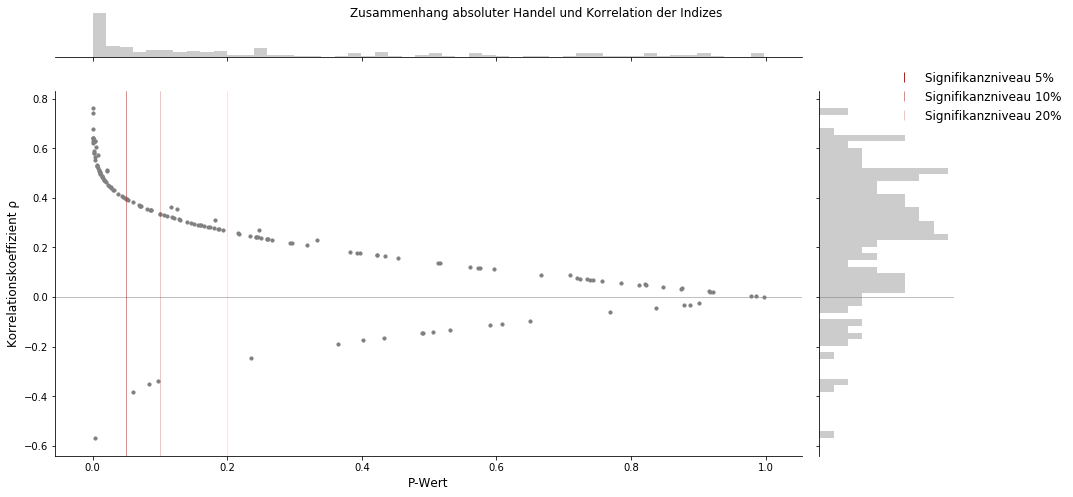

In [95]:
plot = sns.jointplot(y = correlation, x = pval, marginal_kws=dict(bins = 50), color = "grey", s = 10)
plot.fig.set_figwidth(15)
plot.fig.set_figheight(7)

plot.ax_joint.axhline(y=0, color = "grey", linewidth = 0.5)
plot.ax_joint.axvline(x=0.05, color = "red", linewidth = 0.5, label = "Signifikanzniveau 5%")
plot.ax_joint.axvline(x=0.1, color = "red", linewidth = 0.5, alpha = 0.5, label = "Signifikanzniveau 10%")
plot.ax_joint.axvline(x=0.2, color = "red", linewidth = 0.5, alpha = 0.25, label = "Signifikanzniveau 20%")
plt.axhline(y = 0, color = "grey", linewidth = 0.5)

fivepercent = lines.Line2D([], [], color='red', marker='|', alpha = 1, linestyle='None',
                          markersize=10, markeredgewidth=1, label='Signifikanzniveau 5%')
tenpercent = lines.Line2D([], [], color='red', marker='|', alpha = 0.5, linestyle='None',
                          markersize=10, markeredgewidth=1, label='Signifikanzniveau 10%')
twentypercent = lines.Line2D([], [], color='red', marker='|', alpha = 0.25, linestyle='None',
                          markersize=10, markeredgewidth=1, label='Signifikanzniveau 20%')

plt.legend(handles = [fivepercent, tenpercent,twentypercent], loc = (0.5,0.9), frameon=False, fontsize = 12)

#plt.suptitle("Correlations between Trade Volume and Index Correlation")
plot.set_axis_labels('P-Wert', 'Korrelationskoeffizient \u03C1', fontsize=12)

plt.tight_layout()

plt.suptitle("Zusammenhang absoluter Handel und Korrelation der Indizes", fontsize = 14)

# Analyseteil -----------------------------------------------------------------------------------------------
significant5 = len(significant_corr["5%"])/len(correlation)*100
significant10 = len(significant_corr["10%"])/len(correlation)*100
significant20 = len(significant_corr["20%"])/len(correlation)*100

print("signifikante Korrelationen (0.05): {}%".format(round(len(test[(test["pval_correlation"]<0.05)])/len(correlation)*100,2)))
print("signifikante Korrelationen (0.10): {}%".format(round(len(test[(test["pval_correlation"]<0.1)])/len(correlation)*100,2)))
print("signifikante Korrelationen (0.20): {}%".format(round(len(test[(test["pval_correlation"]<0.2)])/len(correlation)*100,2)))

print("\nsignifikante positive Korrelationen:\n     0.05: {}%".format(round(significant5,2)),
     "\n     0.10: {}%".format(round(significant10,2)),
     "\n     0.20: {}%".format(round(significant20,2)),
     "\n\n ----total positive Korrelationen: {}% ({}/{})----".format(round(len(positive)/len(correlation)*100,2),
                                                                    len(positive),anzahl))

print("\nBetrachtung ausschließlich signifikanter Korrelationskoeffizienten:")
sig_corr = test[test["pval_correlation"]<0.05]
print("Anteil positiv unter signifikanten Korrelationen (5%): {}%".format(round(len(sig_corr[sig_corr["correlation"]>0])/len(sig_corr),4)*100))

sig_corr = test[test["pval_correlation"]<0.1]
print("Anteil positiv unter signifikanten Korrelationen (10%): {}%".format(round(len(sig_corr[sig_corr["correlation"]>0])/len(sig_corr),4)*100))

sig_corr = test[test["pval_correlation"]<0.2]
print("Anteil positiv unter signifikanten Korrelationen (20%): {}%".format(round(len(sig_corr[sig_corr["correlation"]>0])/len(sig_corr),4)*100))

In [96]:
#Hypothesentest (t-Test)
#Teststatistik
print("H\u2080: tatsächlicher Mittelwert der Korrelationskoeffizienten ist 0")
print("H\u2081: tatsächlicher Mittelwert der Korrelationskoeffizienten ist signfikant größer als 0\n")

sample = np.array(test["correlation"].to_list())
T = n**0.5*((µS - µ0)/stdS) #Teststatistik
ttest = sp.stats.ttest_1samp(sample, popmean = 0) #p-Wert muss durch 2 geteilt werden, da es sich um einen einseitigen Test handelt
print("Teststatistik:",ttest[0])
print("p-Wert:", ttest[1]/2, "- Entscheidung: Nullhypothese ablehnen; Mittelwert ist größer als Null")

H₀: tatsächlicher Mittelwert der Korrelationskoeffizienten ist 0
H₁: tatsächlicher Mittelwert der Korrelationskoeffizienten ist signfikant größer als 0

Teststatistik: 13.060410369758243
p-Wert: 6.447666871158921e-27 - Entscheidung: Nullhypothese ablehnen; Mittelwert ist größer als Null


In [97]:
correlation_trade = pd.DataFrame(columns = remaining_countries, index = remaining_countries)
pval_trade = pd.DataFrame(columns = remaining_countries, index = remaining_countries)

list_correlations1 = []

for element in list(test.index):
    first = element[:element.find(" ")]
    second = element[element.find(" ")+3:]
    
    #translate to countries
    country1 = symbol_to_country[first]  
    country2 = symbol_to_country[second]
    
    #place into dataframe
    ##correlation
    correlation_trade.loc[country1,country2]=test.loc[element,"correlation"]
    correlation_trade.loc[country2,country1]=test.loc[element,"correlation"]
    
    list_correlations1.append(test.loc[element,"correlation"])
    
    #pvalues
    pval_trade.loc[country1,country2]=test.loc[element,"pval_correlation"]
    pval_trade.loc[country2,country1]=test.loc[element,"pval_correlation"]

correlation_trade.fillna(1, inplace = True)
pval_trade.fillna(1, inplace = True)

Anzahl der individuellen Länderpaare: 153


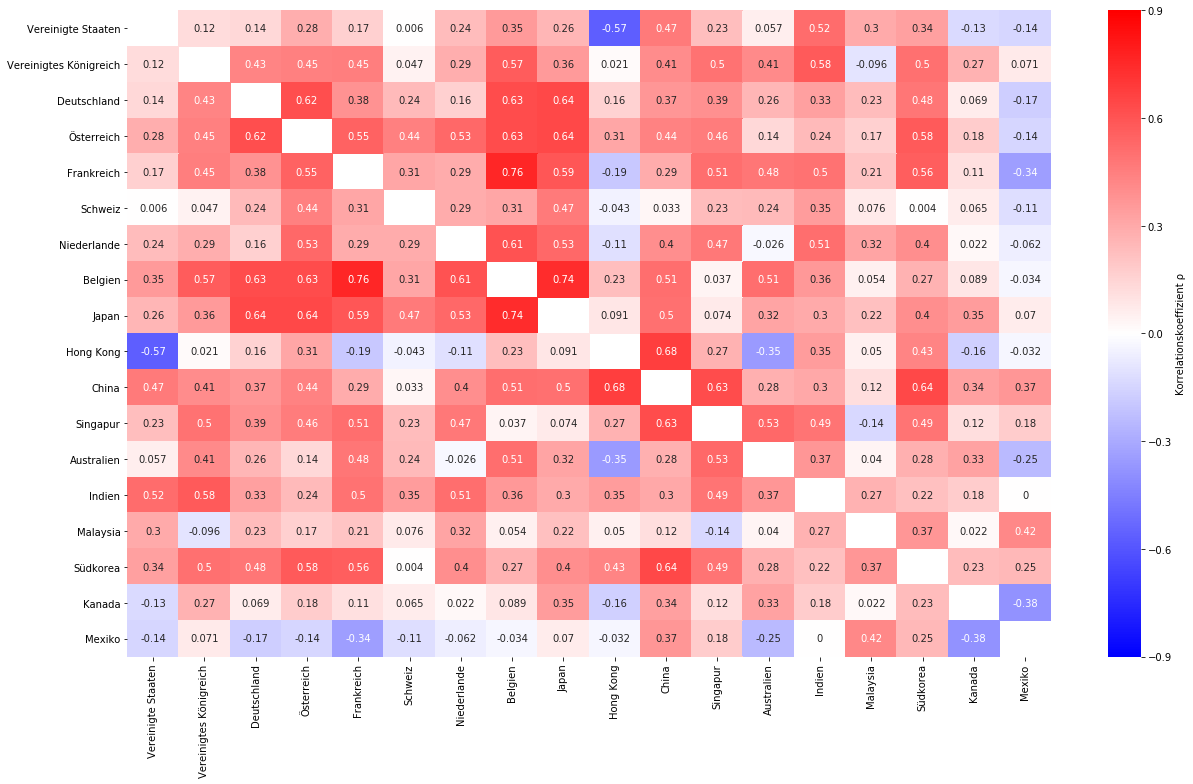

In [98]:
correlation_trade.index = translate_countries(correlation_trade.index.to_list())
correlation_trade.columns = translate_countries(correlation_trade.columns.to_list())

correlation_trade = correlation_trade.round(3).replace(-1,np.nan).replace(1,np.nan).replace(-0.000,0)

plt.subplots(figsize=(18, 11)) #vorher 20,10
sns.heatmap(correlation_trade, annot = True, cmap = "bwr", mask = correlation_trade > 1-0.0000000000001, 
            vmax = 0.9, vmin = -0.9, cbar_kws={'label': 'Korrelationskoeffizient \u03C1'})
plt.title("Korrelationskoeffizienten für den Zusammenhang des gesamten bilateralen Handels und der gleitenden Korrelationen der Länderpaare ")

plt.tight_layout()

print("Anzahl der individuellen Länderpaare:", len(results.keys()))

In [99]:
correlations = np.array(list_correlations1)

trade1summary = correlation_trade.describe().T
trade1summary.loc["Insgesamt","count"]= len(correlations)
trade1summary.loc["Insgesamt","mean"]= np.mean(correlations)
trade1summary.loc["Insgesamt","std"]= np.std(correlations)
trade1summary.loc["Insgesamt","min"]= min(correlations)
trade1summary.loc["Insgesamt","max"]= max(correlations)
trade1summary.loc["Insgesamt","25%"]= np.percentile(correlations, 25)
trade1summary.loc["Insgesamt","50%"]= np.percentile(correlations, 50)
trade1summary.loc["Insgesamt","75%"]= np.percentile(correlations, 75)

trade1summary.rename(columns = {"count":"Anzahl","mean":"µ","std":"\u03C3"}, inplace = True)

trade1summary = trade1summary.round(3)
print("Auswertung der Korrelationskoeffizienten des Zusammenhangs zwischen Indexkorrelationen und Gesamthandel")
display(trade1summary)
print("*Korrelationen mit eigenem Index wurden vernachlässigt")
print("**bezieht sich lediglich auf individuelle Länderpaare")

,Anzahl,µ,σ,min,25%,50%,75%,max
Vereinigte Staaten,17.0,0.155,0.261,-0.569,0.057,0.231,0.296,0.519
Vereinigtes Königreich,17.0,0.316,0.209,-0.096,0.122,0.405,0.452,0.581
Deutschland,17.0,0.316,0.217,-0.175,0.164,0.331,0.433,0.643
Österreich,17.0,0.384,0.217,-0.145,0.242,0.443,0.553,0.642
Frankreich,17.0,0.332,0.282,-0.340,0.208,0.382,0.512,0.761
Schweiz,17.0,0.175,0.177,-0.113,0.033,0.235,0.311,0.469
Niederlande,17.0,0.286,0.222,-0.108,0.164,0.292,0.474,0.606
Belgien,17.0,0.390,0.255,-0.034,0.228,0.362,0.606,0.761
Japan,17.0,0.385,0.207,0.070,0.256,0.356,0.530,0.742
Hong Kong,17.0,0.067,0.304,-0.569,-0.108,0.050,0.273,0.680


*Korrelationen mit eigenem Index wurden vernachlässigt
**bezieht sich lediglich auf individuelle Länderpaare


In [100]:
#testen, ob ein Zusammenhang mit dem Entwicklungsstatus besteht
temp = pd.DataFrame.from_dict(country_classification, orient = "index").rename(columns = {0:"Klassifizierung"})
temp.index = translate_countries(temp.index.to_list())
trade1summary = trade1summary.join(temp).groupby(by = "Klassifizierung").mean()

trade1summary.loc["Developed","Anzahl"] = int(number_developed)
trade1summary.loc["Emerging","Anzahl"] = int(number_emerging)
trade1summary = trade1summary.round(3)
display(trade1summary)

,Anzahl,µ,σ,min,25%,50%,75%,max
Klassifizierung,,,,,,,,
Developed,13.0,0.265,0.232,-0.227,0.125,0.297,0.425,0.609
Emerging,5.0,0.252,0.173,-0.097,0.150,0.255,0.363,0.547


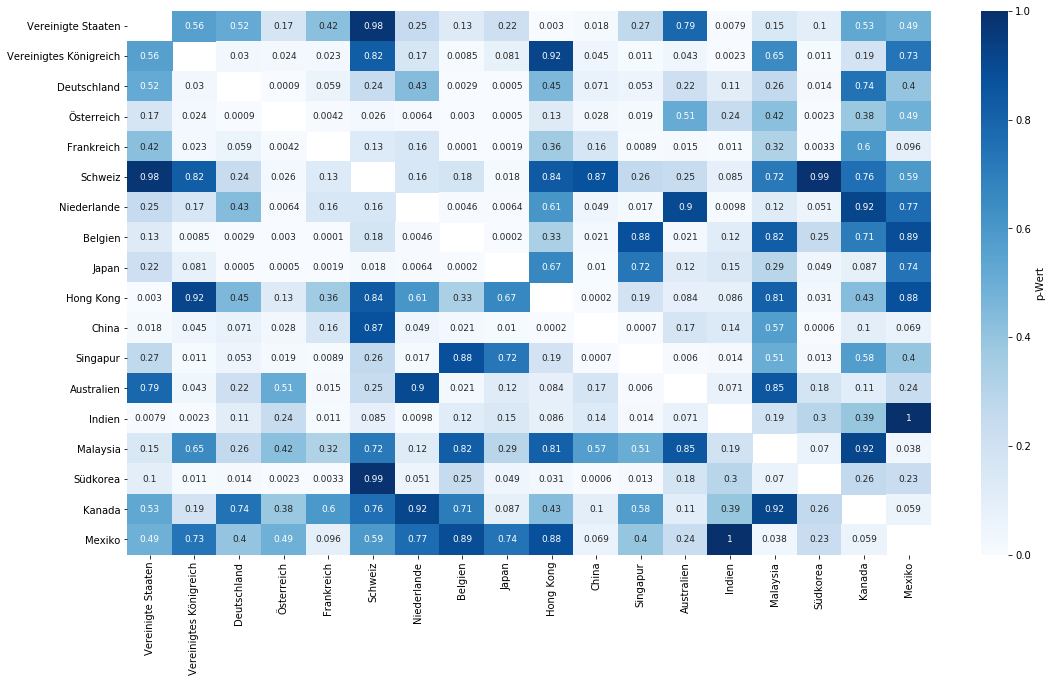

In [101]:
pval_trade.index = translate_countries(pval_trade.index.to_list())
pval_trade.columns = translate_countries(pval_trade.columns.to_list())

plt.subplots(figsize=(18, 10)) #vorher 18,8
sns.heatmap(pval_trade.round(4), annot = True, cmap = "Blues", mask = pval_trade > 1-1/10**10, annot_kws={"fontsize":9}, cbar_kws={"label":"p-Wert"})
plt.title("p-Werte der Korrelationskoeffizienten des Zusammenhangs zwischen dem bilateralen Gesamthandel und der Indexkorrelation")

### 2.2.2. Untersuchung Ursache und Wirkung
<a id='GesamthandelUrsacheEffekt'></a>

In [102]:
#Funktion, welche zwei Reihen miteinander verschiebt
def shift_data(x,y,lags):
    #shifts y by "lags" positions 
    
    x = np.array(x)
    y = np.array(y)
    
    if len(x)!=len(y):
        raise "x and y have be the same length"
    if lags >= 0:
        y = sp.ndimage.interpolation.shift(y, lags, cval=0)
        x = x[lags:]
        y = y[lags:]
    else:
        lags = int(((lags)**2)**0.5)
        x = sp.ndimage.interpolation.shift(x, lags, cval=0)
        x = x[lags:]
        y = y[lags:]
    return x,y


Anteil positiver Lags: 0.9215686274509803


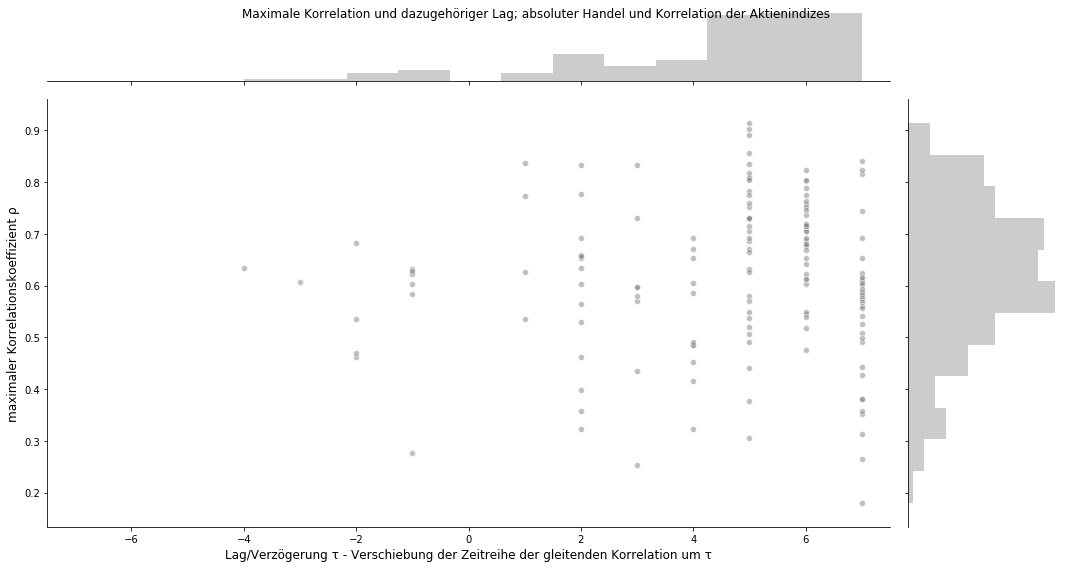

In [103]:
#Zusammenhang zwischen wirtschaftlicher Integration und Korrelation zwischen Aktienindizes darstellen

lags = 7

datarange = np.arange(lags*-1,lags + 1)

corr_list = []
lag_list = []
pval_list = []


for temp_pair in tqdm(results.keys()):

    temp = results[temp_pair]["dataframe"]
    korrelation = temp["Correlation({})".format(window)].to_list()
    handel = temp["total imports"].to_list()
    #handel = temp["Trade-to-GDP"].to_list()
    
    diff_corr = np.diff(korrelation)
    diff_handel = np.diff(handel)    

    lagcorrelation = []
    lag_pval = []
    for lag in datarange:
        data1,data2 = shift_data(handel,korrelation,lag)
        lagcorrelation.append(sp.stats.pearsonr(data1, data2)[0])
        lag_pval.append(sp.stats.pearsonr(data1, data2)[1]) 
        
    maxcor = max(lagcorrelation)
    maxlag = dict(zip(lagcorrelation, datarange))[maxcor]
    maxpval = dict(zip(lagcorrelation, lag_pval))[maxcor]
    
    corr_list.append(maxcor)
    lag_list.append(maxlag)
    pval_list.append(maxpval)


plot = sns.jointplot(lag_list, corr_list, marginal_kws=dict(bins=12), 
                     color = "grey", edgecolor = "w", ratio = 5, alpha = 0.5)
plot.ax_marg_x.set_xlim(-7.5, 7.5)
#plt.suptitle("Correlations between Trade Volume and Index Correlation")
plot.set_axis_labels('Lag/Verzögerung \u03C4 - Verschiebung der Zeitreihe der gleitenden Korrelation um \u03C4',
                     'maximaler Korrelationskoeffizient \u03C1', fontsize=12)
plot.fig.set_figheight(8)
plot.fig.set_figwidth(15)

plt.tight_layout()

plt.suptitle("Maximale Korrelation und dazugehöriger Lag; absoluter Handel und Korrelation der Aktienindizes", fontsize = 14)

lag_list = np.array(lag_list)
print("Anteil positiver Lags:",len(lag_list[lag_list > 0])/len(lag_list))

In [104]:
classification_total_trade = {}
classification_pairs = ["Developed - Developed", "Developed - Emerging","Emerging - Emerging" ]
pair_counts = {}

for element in classification_pairs:
    classification_total_trade[element] = pd.DataFrame(index = pd.PeriodIndex(np.arange(1994,2019), freq = "Y"))
    classification_total_trade[element].index.name = 'date'
    pair_counts[element] = 0
    
for element in results.keys():
    first = element[:element.find(" ")]
    second = element[element.find(" ")+3:]
    
    #translate to countries
    country1 = symbol_to_country[first]    
    country2 = symbol_to_country[second]
    
    if country_classification[country1] == "Developed" and country_classification[country2] == "Developed":
        classification_total_trade["Developed - Developed"] = classification_total_trade["Developed - Developed"].join(pd.DataFrame(results[element]["dataframe"]["total imports"]).rename(columns = {"total imports":element}))
        pair_counts["Developed - Developed"] += 1
        
    elif country_classification[country1] == "Developed" and country_classification[country2] == "Emerging":
        classification_total_trade["Developed - Emerging"] = classification_total_trade["Developed - Emerging"].join(pd.DataFrame(results[element]["dataframe"]["total imports"]).rename(columns = {"total imports":element}))
        pair_counts["Developed - Emerging"] += 1
        
    elif country_classification[country1] == "Emerging" and country_classification[country2] == "Developed":
        classification_total_trade["Developed - Emerging"] = classification_total_trade["Developed - Emerging"].join(pd.DataFrame(results[element]["dataframe"]["total imports"]).rename(columns = {"total imports":element}))
        pair_counts["Developed - Emerging"] += 1
        
    elif country_classification[country1] == "Emerging" and country_classification[country2] == "Emerging":
        classification_total_trade["Emerging - Emerging"] = classification_total_trade["Emerging - Emerging"].join(pd.DataFrame(results[element]["dataframe"]["total imports"]).rename(columns = {"total imports":element}))  
        pair_counts["Emerging - Emerging"] += 1
        
sum_trade = pd.DataFrame(index = pd.PeriodIndex(np.arange(1994,2019), freq = "Y"))
for element in classification_pairs:
    classification_total_trade[element] = classification_total_trade[element].dropna(how = "all").fillna(method = "ffill").fillna(method = "bfill")
    classification_total_trade[element]["Sum"] = classification_total_trade[element].sum(axis=1)
    sum_trade = sum_trade.join(classification_total_trade[element]["Sum"]).rename(columns = {"Sum":element})
    
sum_trade = sum_trade.dropna(how = "all").fillna(method = "ffill")

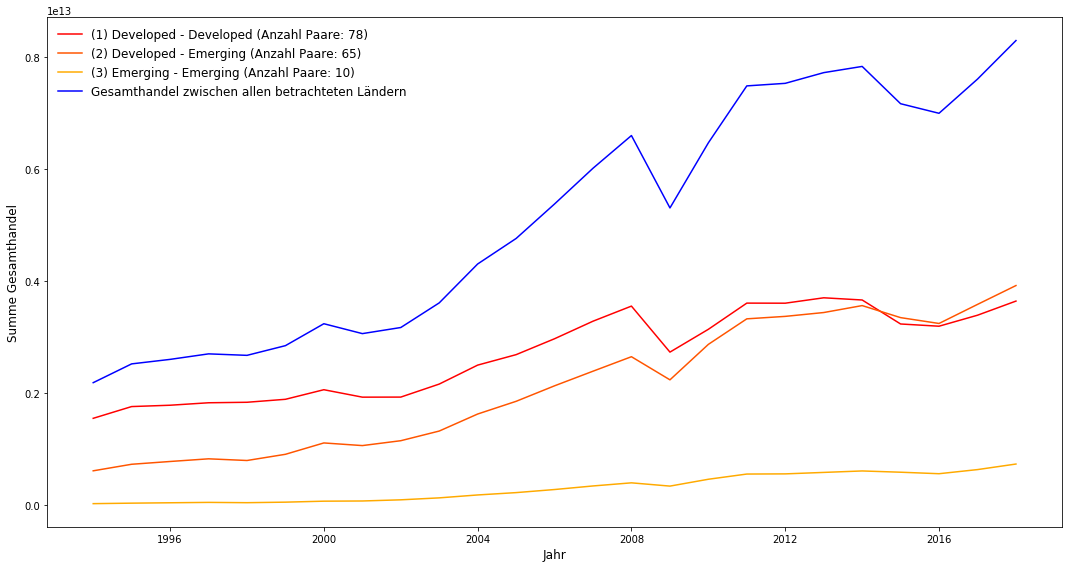

In [105]:
cmap = matplotlib.cm.autumn

for i, element in enumerate(classification_pairs):
    if i == 0:
        all_countries_trade = sum_trade[element]
    else:
        all_countries_trade = all_countries_trade + sum_trade[element]
all_countries_trade.index = all_countries_trade.index.to_timestamp()

plt.figure(figsize = (15,8))
for i, element in enumerate(classification_pairs):
    sum_trade[element].index = sum_trade[element].index.to_timestamp()
    plt.plot(sum_trade[element], label = "({}) ".format(i+1) + element + " (Anzahl Paare: " +str(pair_counts[element])+")", color = cmap(i/len(classification_pairs)))

plt.plot(all_countries_trade, label = "Gesamthandel zwischen allen betrachteten Ländern", color = "blue")
#plt.fill_between(x = means_trade.index, y1 = means_trade["Developed - Developed"].rolling(window = 250).mean()-means_trade["Developed - Emerging"].rolling(window = 250).mean(), color = "grey", alpha = 0.15, label = "\u0394 Developed - Emerging (1-2)")
plt.legend(frameon = False, fontsize = 12)
plt.xlabel("Jahr", fontsize = 12)
plt.ylabel("Summe Gesamthandel", fontsize = 12)
plt.title("Gesamthandel nach Länderklassifizierung", fontsize = 14)

plt.tight_layout()

## 2.3. Zusammenhang Korrelation und relativer wirtschaftlicher Integration
<a id='KorrelationIntegration'></a>

In [106]:
#BIP Daten aus csv laden
all_gdp = pd.read_csv("Data/GDP/GDP.csv", skiprows = 4).set_index("Country Name")
all_gdp = all_gdp.drop(["Indicator Name","Indicator Code", "Country Code", "Unnamed: 64"], axis = 1)

In [107]:
gdp = {}
for element in countries:
    if element == "HongKong":
        gdp[element]= all_gdp.loc["Hong Kong SAR, China"]
        continue
    
    if element == "UK":
        gdp[element]= all_gdp.loc["United Kingdom"]
        continue

    if element == "SouthKorea":
        gdp[element]= all_gdp.loc["Korea, Rep."]
        continue
        
    if element == "USA":
        gdp[element]= all_gdp.loc["United States"]
        continue
        
    gdp[element] = all_gdp.loc[element]
    
for element in gdp.keys():
    gdp[element] = pd.DataFrame(gdp[element])
    gdp[element].columns = ["GDP"]
    gdp[element].index = pd.to_datetime(gdp[element].index).to_period("Y")

In [108]:
for element in countries:
    try: 
        gdp[element].loc["2010"]
        print(element, ": worked")
    except:
        print(element, ": did not work")

USA : worked
UK : worked
Germany : worked
Austria : worked
France : worked
Switzerland : worked
Netherlands : worked
Belgium : worked
Japan : worked
HongKong : worked
China : worked
Singapore : worked
Australia : worked
India : worked
Malaysia : worked
SouthKorea : worked
Canada : worked
Mexico : worked


In [109]:
for element in results.keys():
    
    temp = results[element]["dataframe"]
    
    #extract names from index pair
    first = element[:element.find(" ")]
    second = element[element.find(" ")+3:]
    
    #translate to countries
    country1 = symbol_to_country[first]  
    country2 = symbol_to_country[second]

    #if columns exist already
    try:
        temp.drop("GDP {}".format(country1), axis = 1, inplace = True)
        temp.drop("GDP {}".format(country2), axis = 1, inplace = True)
        temp.drop("Sum GDP", axis = 1, inplace = True)
    except:
        pass
    
    #add to dataframe
    ## GDP
    temp = temp.join(gdp[country1]["GDP"])
    temp.rename(columns = {"GDP":"GDP {}".format(country1)}, inplace = True)
    
    temp = temp.join(gdp[country2]["GDP"])
    temp.rename(columns = {"GDP":"GDP {}".format(country2)}, inplace = True) 
    
    #Summe GDP
    temp["Sum GDP"] = temp["GDP {}".format(country1)] + temp["GDP {}".format(country2)]
    temp["Trade-to-GDP"] = temp["total imports"]/temp["Sum GDP"]
        
    results[element]["dataframe"] = temp

In [110]:
print("Beispielausschnitt für ein Index-/Länderpaar")
results['^GSPC + ^GDAXIP']["dataframe"].head()

,Correlation(66),total imports,standardCorrelation,standardTrade,GDP USA,GDP Germany,Sum GDP,Trade-to-GDP
date,,,,,,,,
1994,0.165096,6.028010e+10,-0.533979,-7.563209e+10,7.287236e+12,2.205074e+12,9.492310e+12,0.006350
1995,0.273573,6.965813e+10,-0.425502,-6.625406e+10,7.639749e+12,2.585792e+12,1.022554e+13,0.006812
1996,0.679344,7.286551e+10,-0.019731,-6.304668e+10,8.073122e+12,2.497245e+12,1.057037e+13,0.006893
1997,0.734108,7.718667e+10,0.035033,-5.872551e+10,8.577554e+12,2.211990e+12,1.078954e+13,0.007154
1998,0.773438,8.866907e+10,0.074363,-4.724311e+10,9.062818e+12,2.238991e+12,1.130181e+13,0.007846


In [111]:
years = np.arange(min(results['^GSPC + ^GDAXIP']["dataframe"].index).year,max(results['^GSPC + ^GDAXIP']["dataframe"].index).year+1)

In [113]:
#Korrelation zwischen gleitender Korrelation und Trade-to-GDP berechnen

#dataframe erstellen
correlation_trade_intensity = pd.DataFrame(columns = remaining_countries, index = remaining_countries)
pval_trade_intensity = pd.DataFrame(columns = remaining_countries, index = remaining_countries)

list_correlations2 = []
list_pvals2 = []

#Berechnung für jedes Paar durchführen
for element in results.keys():
    correlation_country = results[element]["dataframe"]["Correlation({})".format(window)].to_numpy()
    trade_intensity = results[element]["dataframe"]["Trade-to-GDP"].to_numpy()

    tempcorr = sp.stats.pearsonr(correlation_country, trade_intensity)
    correlation = tempcorr[0]
    pval_correlation = tempcorr[1]
    
    results[element]["correlation intensity"] = correlation
    results[element]["pval intensity"] = pval_correlation
    
    #in dataframe einordnen
    first = element[:element.find(" ")]
    second = element[element.find(" ")+3:]
    
    #translate to countries
    country1 = symbol_to_country[first]  
    country2 = symbol_to_country[second]

    ##correlation
    correlation_trade_intensity.loc[country1,country2] = correlation
    correlation_trade_intensity.loc[country2,country1] = correlation
    
    #pvalues
    pval_trade_intensity.loc[country1,country2]=pval_correlation
    pval_trade_intensity.loc[country2,country1]=pval_correlation
    
    list_correlations2.append(correlation)
    list_pvals2.append(pval_correlation)
    
correlation_trade_intensity.fillna(1, inplace = True)
pval_trade_intensity.fillna(1, inplace = True)

#Ländernamen übersetzen
correlation_trade_intensity.index = translate_countries(correlation_trade_intensity.index.to_list())
correlation_trade_intensity.columns = translate_countries(correlation_trade_intensity.columns.to_list())

pval_trade_intensity.index = translate_countries(pval_trade_intensity.index.to_list())
pval_trade_intensity.columns = translate_countries(pval_trade_intensity.columns.to_list())

### Auswertung
<a id='AuswertungIntegration'></a>

Text(0.5, 1.0, 'Zusammenhang zwischen gleitender Korrelation und bilateralem Trade-to-GDP')

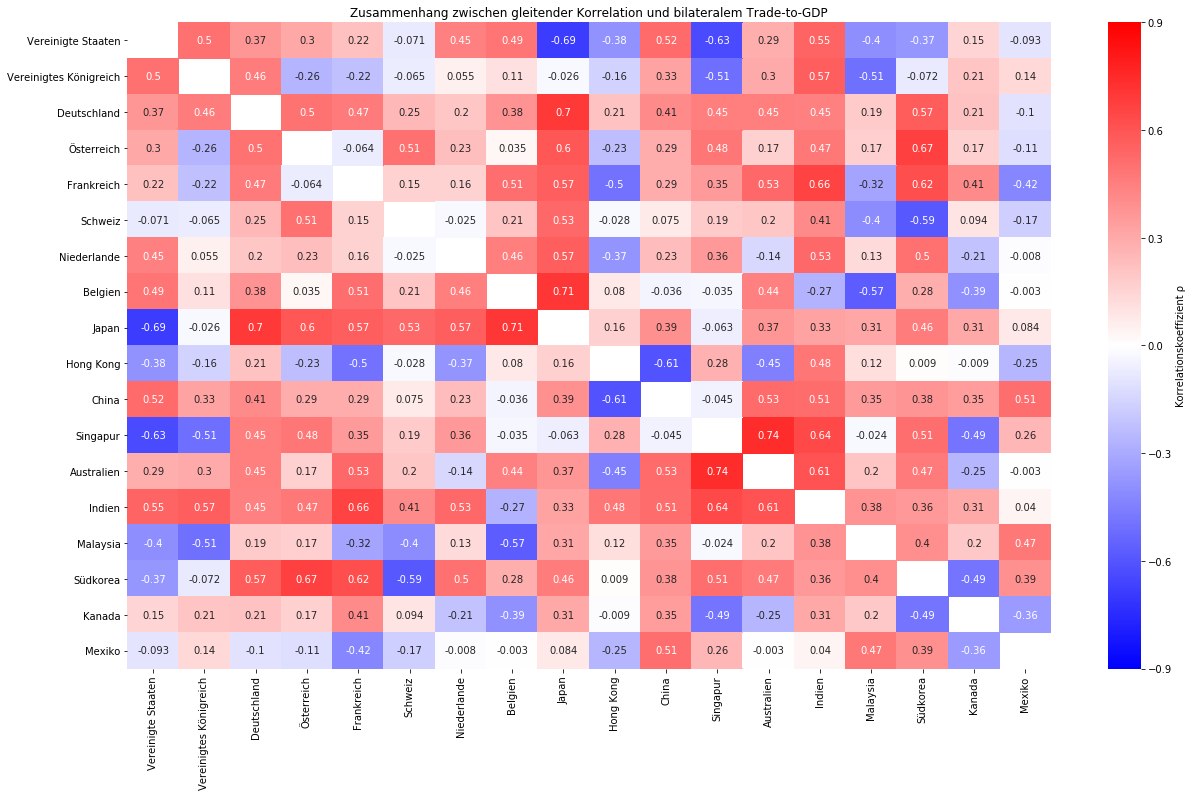

In [114]:
correlation_trade_intensity = correlation_trade_intensity.round(3).replace(-1,np.nan).replace(1,np.nan)

plt.subplots(figsize=(18, 11))
sns.heatmap(correlation_trade_intensity, annot = True, cmap = "bwr", 
            mask = correlation_trade_intensity > 1-0.0000000000001, 
            vmax = 0.9, vmin = -0.9, cbar_kws={'label': 'Korrelationskoeffizient \u03C1'})
#sns.heatmap(correlation_trade, annot = True, cmap = "Greys", mask = correlation_trade !=1, cbar = False)

plt.tight_layout()

plt.title("Zusammenhang zwischen gleitender Korrelation und bilateralem Trade-to-GDP", fontsize = 15)

In [115]:
correlations = np.array(list_correlations2)


trade2summary = correlation_trade_intensity.describe().T
trade2summary.loc["Insgesamt","count"]= len(correlations)
trade2summary.loc["Insgesamt","mean"]= np.mean(correlations)
trade2summary.loc["Insgesamt","std"]= np.std(correlations)
trade2summary.loc["Insgesamt","min"]= min(correlations)
trade2summary.loc["Insgesamt","max"]= max(correlations)
trade2summary.loc["Insgesamt","25%"]= np.percentile(correlations, 25)
trade2summary.loc["Insgesamt","50%"]= np.percentile(correlations, 50)
trade2summary.loc["Insgesamt","75%"]= np.percentile(correlations, 75)
trade2summary.rename(columns = {"count":"Anzahl","mean":"µ","std":"\u03C3"}, inplace = True)

trade2summary = trade2summary.round(3)

print("Auswertung der Korrelationskoeffizienten des Zusammenhangs zwischen Indexkorrelationen und relativer wirtschaftlicher Integration")
display(trade2summary)
print("*Korrelationen mit eigenem Index wurden vernachlässigt")
print("**bezieht sich lediglich auf individuelle Länderpaare")

,Anzahl,µ,σ,min,25%,50%,75%,max
Vereinigte Staaten,17.0,0.071,0.424,-0.685,-0.366,0.221,0.447,0.545
Vereinigtes Königreich,17.0,0.050,0.326,-0.513,-0.160,0.055,0.298,0.567
Deutschland,17.0,0.363,0.186,-0.101,0.213,0.410,0.464,0.697
Österreich,17.0,0.231,0.287,-0.263,0.035,0.229,0.480,0.673
Frankreich,17.0,0.201,0.377,-0.499,-0.064,0.295,0.509,0.661
Schweiz,17.0,0.075,0.295,-0.590,-0.065,0.094,0.208,0.534
Niederlande,17.0,0.184,0.277,-0.374,-0.008,0.199,0.447,0.569
Belgien,17.0,0.141,0.346,-0.574,-0.035,0.109,0.444,0.710
Japan,17.0,0.312,0.347,-0.685,0.163,0.368,0.566,0.710
Hong Kong,17.0,-0.097,0.304,-0.610,-0.374,-0.028,0.115,0.479


*Korrelationen mit eigenem Index wurden vernachlässigt
**bezieht sich lediglich auf individuelle Länderpaare


In [116]:
#testen, ob ein Zusammenhang mit dem Entwicklungsstatus besteht
temp = pd.DataFrame.from_dict(country_classification, orient = "index").rename(columns = {0:"Klassifizierung"})
temp.index = translate_countries(temp.index.to_list())
trade2summary = trade2summary.join(temp).groupby(by = "Klassifizierung").mean()

trade2summary.loc["Developed","Anzahl"] = int(number_developed)
trade2summary.loc["Emerging","Anzahl"] = int(number_emerging)
trade2summary = trade2summary.round(3)
print("Auswertung der Korrelationskoeffizienten nach Länderklassifizierung für den Zusammenhang zwischen den Indexkorrelationen und der relativen wirtschaftlichen Integration (nach IHS Markit, 2018)")
display(trade2summary)

,Anzahl,µ,σ,min,25%,50%,75%,max
Klassifizierung,,,,,,,,
Developed,13.0,0.150,0.323,-0.497,-0.061,0.205,0.393,0.619
Emerging,5.0,0.197,0.306,-0.494,0.034,0.276,0.382,0.569


Anteil positive Indexpaare: 67.974%
Anzahl Indexpaare mit positiver Korrelation: 104


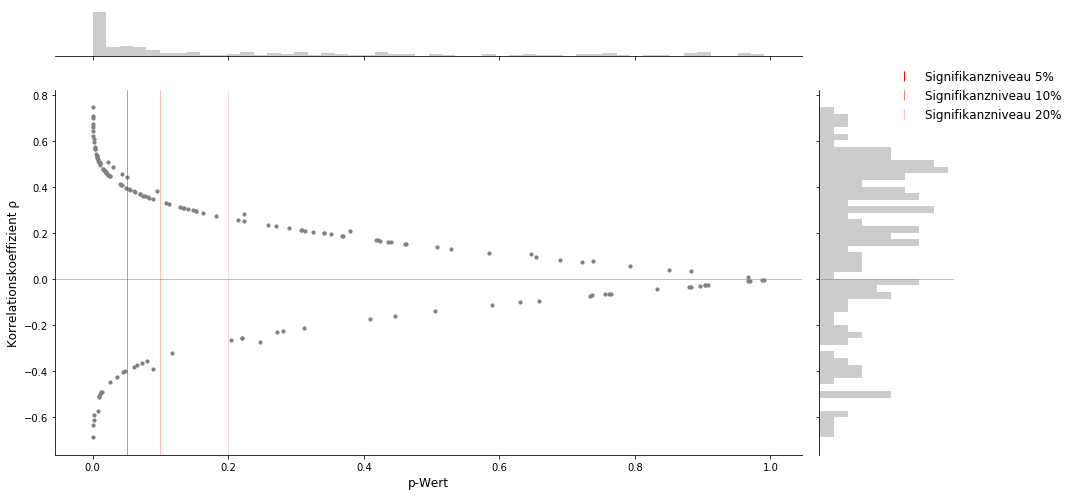

In [117]:
plot = sns.jointplot(y = list_correlations2, x = list_pvals2, marginal_kws=dict(bins = 50), color = "grey", s = 10)
plot.fig.set_figwidth(15)
plot.fig.set_figheight(7)

plot.ax_joint.axhline(y=0, color = "grey", linewidth = 0.5)
plot.ax_joint.axvline(x=0.05, color = "red", linewidth = 0.5, label = "Signifikanzniveau 5%")
plot.ax_joint.axvline(x=0.1, color = "red", linewidth = 0.5, alpha = 0.5, label = "Signifikanzniveau 10%")
plot.ax_joint.axvline(x=0.2, color = "red", linewidth = 0.5, alpha = 0.25, label = "Signifikanzniveau 20%")
plt.axhline(y = 0, color = "grey", linewidth = 0.5)

fivepercent = lines.Line2D([], [], color='red', marker='|', alpha = 1, linestyle='None',
                          markersize=10, markeredgewidth=1, label='Signifikanzniveau 5%')
tenpercent = lines.Line2D([], [], color='red', marker='|', alpha = 0.5, linestyle='None',
                          markersize=10, markeredgewidth=1, label='Signifikanzniveau 10%')
twentypercent = lines.Line2D([], [], color='red', marker='|', alpha = 0.25, linestyle='None',
                          markersize=10, markeredgewidth=1, label='Signifikanzniveau 20%')

plt.legend(handles = [fivepercent, tenpercent,twentypercent], loc = (0.5,0.9), frameon=False, fontsize = 12)

#plt.suptitle("Correlations between Trade Volume and Index Correlation")
plot.set_axis_labels('p-Wert', 'Korrelationskoeffizient \u03C1', fontsize=12)
plt.suptitle("Verteilung von Korrelationskoeffizienten und p-Werten des Zusammenhangs der relativen wirtschaftlichen Integration mit den Indexkorrelationen ")
plt.tight_layout()

intensity_correlations = np.array(list_correlations2)
temp_percentage = len(intensity_correlations[intensity_correlations > 0])/len(intensity_correlations)
print("Anteil positive Indexpaare: {}%".format(round(temp_percentage*100,3)))
print("Anzahl Indexpaare mit positiver Korrelation:",len(intensity_correlations[intensity_correlations > 0]))

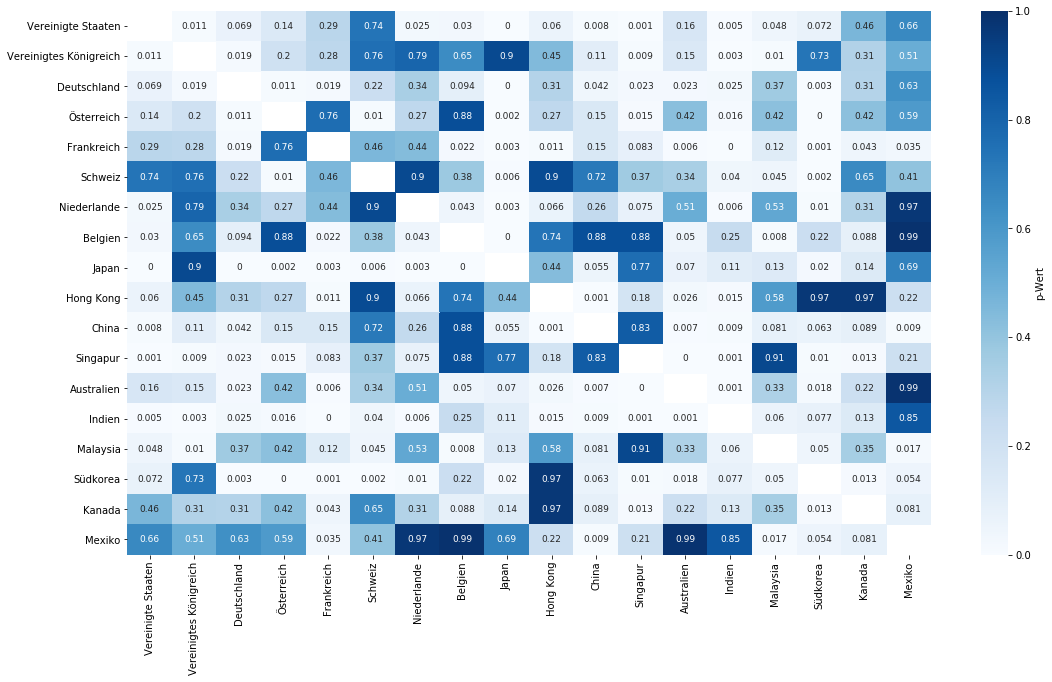

In [118]:
plt.subplots(figsize=(18, 10)) #vorher 18,8
sns.heatmap(pval_trade_intensity.round(3), annot = True, cmap = "Blues", 
            mask = pval_trade_intensity > 1-1/10**10, annot_kws={"fontsize":9}, cbar_kws = {"label":"p-Wert"})
plt.title("p-Werte der Korrelationskoeffizienten des Zusammenhangs zwischen relativer wirtschaftlicher Integration und der Indexkorrelation")

In [119]:
pvals = np.array(list_pvals2)
print("Signifikante Werte bei Signifkikanzniveau 0.05:", round(len(pvals[pvals < 0.05])/len(pvals)*100,2), "%")
print("Signifikante Werte bei Signifkikanzniveau 0.1:", round(len(pvals[pvals < 0.1])/len(pvals)*100,2), "%")
print("Signifikante Werte bei Signifkikanzniveau 0.2:", round(len(pvals[pvals < 0.2])/len(pvals)*100,2), "%")

Signifikante Werte bei Signifkikanzniveau 0.05: 39.22 %
Signifikante Werte bei Signifkikanzniveau 0.1: 50.33 %
Signifikante Werte bei Signifkikanzniveau 0.2: 58.17 %


In [120]:
results_correlation2 = pd.DataFrame.from_dict(dict(zip(intensity_correlations,pvals)), orient = "index").reset_index().rename(columns = {"index":"correlation",0:"pvals"})
results_cor_significant5 = results_correlation2[results_correlation2["pvals"] < 0.05]
print("Positive Werte bei Signifkikanzniveau 0.05:", 
      round(len(results_cor_significant5[results_cor_significant5["correlation"]>0])/len(results_cor_significant5),4)*100,"%")

results_cor_significant10 = results_correlation2[results_correlation2["pvals"] < 0.1]
print("Positive Werte bei Signifkikanzniveau 0.1:", 
      round(len(results_cor_significant10[results_cor_significant10["correlation"]>0])/len(results_cor_significant10),4)*100,"%")

results_cor_significant20 = results_correlation2[results_correlation2["pvals"] < 0.2]
print("Positive Werte bei Signifkikanzniveau 0.2:", 
      round(len(results_cor_significant20[results_cor_significant20["correlation"]>0])/len(results_cor_significant20),4)*100,"%")

Positive Werte bei Signifkikanzniveau 0.05: 76.67 %
Positive Werte bei Signifkikanzniveau 0.1: 75.32 %
Positive Werte bei Signifkikanzniveau 0.2: 77.53 %


### 2.3.2. Untersuchung Ursache und Wirkung
<a id='UrsacheWirkungIntegration'></a>


Anteil positiver Lags: 0.5620915032679739


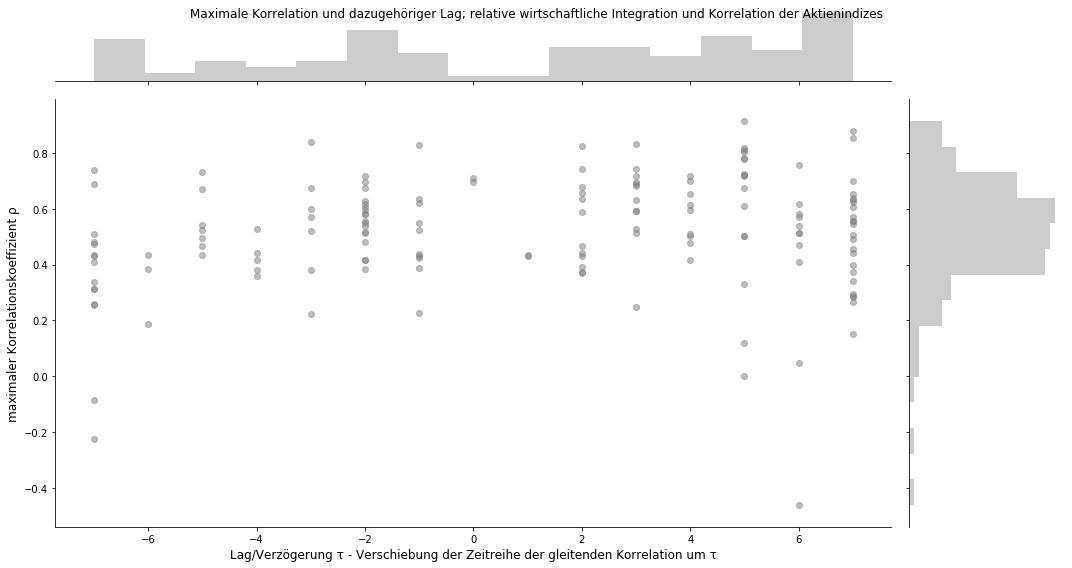

In [121]:
#Zusammenhang zwischen wirtschaftlicher Integration und Korrelation zwischen Aktienindizes darstellen

lags = 7

datarange = np.arange(lags*-1,lags + 1)

corr_list = []
lag_list = []
pval_list = []


for temp_pair in tqdm(results.keys()):

    temp = results[temp_pair]["dataframe"]
    korrelation = temp["Correlation({})".format(window)].to_list()
    #handel = temp["total imports"].to_list()
    handel = temp["Trade-to-GDP"].to_list()
    
    diff_corr = np.diff(korrelation)
    diff_handel = np.diff(handel)    

    lagcorrelation = []
    lag_pval = []
    for lag in datarange:
        data1,data2 = shift_data(handel,korrelation,lag)
        lagcorrelation.append(sp.stats.pearsonr(data1, data2)[0])
        lag_pval.append(sp.stats.pearsonr(data1, data2)[1]) 
        
    maxcor = max(lagcorrelation)
    maxlag = dict(zip(lagcorrelation, datarange))[maxcor]
    maxpval = dict(zip(lagcorrelation, lag_pval))[maxcor]
    
    corr_list.append(maxcor)
    lag_list.append(maxlag)
    pval_list.append(maxpval)


plot = sns.jointplot(lag_list, corr_list, marginal_kws=dict(bins=15), color = "grey", ratio = 5, alpha = 0.5)

#plt.suptitle("Correlations between Trade Volume and Index Correlation")
plot.set_axis_labels('Lag/Verzögerung \u03C4 - Verschiebung der Zeitreihe der gleitenden Korrelation um \u03C4',
                     'maximaler Korrelationskoeffizient \u03C1', fontsize=12)
plot.fig.set_figheight(8)
plot.fig.set_figwidth(15)

plt.tight_layout()

plt.suptitle("Maximale Korrelation und dazugehöriger Lag; relative wirtschaftliche Integration und Korrelation der Aktienindizes", fontsize = 14)

lag_list = np.array(lag_list)
print("Anteil positiver Lags:",len(lag_list[lag_list > 0])/len(lag_list))

In [122]:
classification_trade = {}
classification_pairs = ["Developed - Developed", "Developed - Emerging","Emerging - Emerging" ]
pair_counts = {}

for element in classification_pairs:
    classification_trade[element] = pd.DataFrame(index = np.arange(1994,2019))
    classification_trade[element].index.name = 'date'
    classification_trade[element].index = pd.to_datetime(classification_trade[element].index, format='%Y').to_period("Y")
    pair_counts[element] = 0
    
for element in results.keys():
    first = element[:element.find(" ")]
    second = element[element.find(" ")+3:]
    
    #translate to countries
    country1 = symbol_to_country[first]    
    country2 = symbol_to_country[second]
    
    if country_classification[country1] == "Developed" and country_classification[country2] == "Developed":
        classification_trade["Developed - Developed"] = classification_trade["Developed - Developed"].join(pd.DataFrame(results[element]["dataframe"]["Trade-to-GDP"]).rename(columns = {"Trade-to-GDP":element}))
        pair_counts["Developed - Developed"] += 1
        
    elif country_classification[country1] == "Developed" and country_classification[country2] == "Emerging":
        classification_trade["Developed - Emerging"] = classification_trade["Developed - Emerging"].join(pd.DataFrame(results[element]["dataframe"]["Trade-to-GDP"]).rename(columns = {"Trade-to-GDP":element}))
        pair_counts["Developed - Emerging"] += 1
        
    elif country_classification[country1] == "Emerging" and country_classification[country2] == "Developed":
        classification_trade["Developed - Emerging"] = classification_trade["Developed - Emerging"].join(pd.DataFrame(results[element]["dataframe"]["Trade-to-GDP"]).rename(columns = {"Trade-to-GDP":element}))
        pair_counts["Developed - Emerging"] += 1
        
    elif country_classification[country1] == "Emerging" and country_classification[country2] == "Emerging":
        classification_trade["Emerging - Emerging"] = classification_trade["Emerging - Emerging"].join(pd.DataFrame(results[element]["dataframe"]["Trade-to-GDP"]).rename(columns = {"Trade-to-GDP":element}))  
        pair_counts["Emerging - Emerging"] += 1
        
means_trade = pd.DataFrame(index = np.arange(1994,2019))
means_trade.index = pd.to_datetime(means_trade.index, format='%Y').to_period("Y")
for element in classification_pairs:
    classification_trade[element] = classification_trade[element].dropna(how = "all").fillna(method = "ffill").fillna(method = "bfill")
    classification_trade[element]["Mean"] = classification_trade[element].mean(axis=1)
    means_trade = means_trade.join(classification_trade[element]["Mean"]).rename(columns = {"Mean":element})
    
means_trade = means_trade.dropna(how = "all").fillna(method = "ffill")

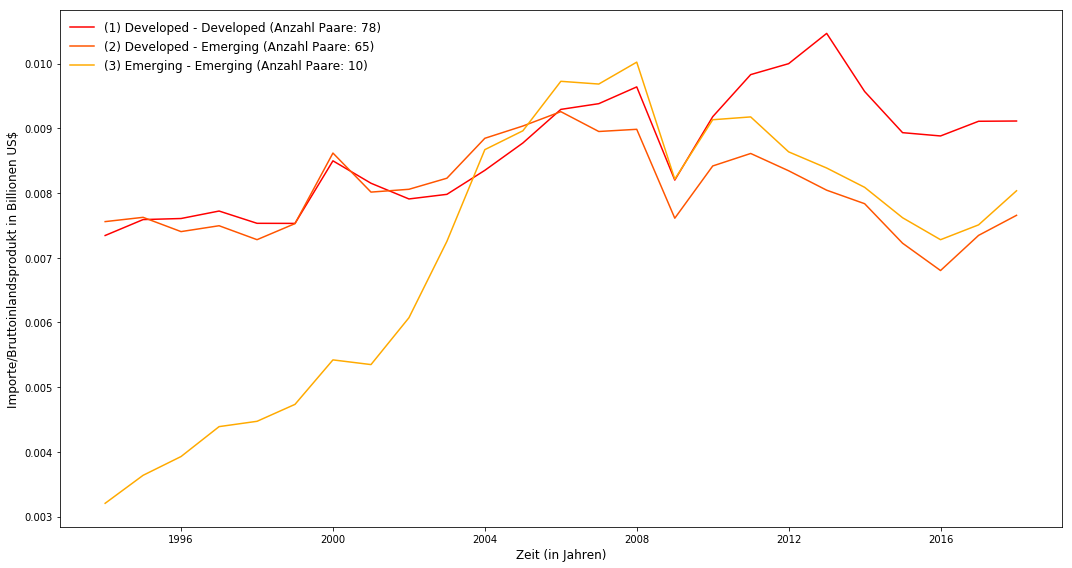

In [123]:
cmap = matplotlib.cm.autumn

plt.figure(figsize = (15,8))
for i, element in enumerate(classification_pairs):
    means_trade[element].index = means_trade[element].index.to_timestamp()
    plt.plot(means_trade[element], label = "({}) ".format(i+1) + element + " (Anzahl Paare: " +str(pair_counts[element])+")", color = cmap(i/len(classification_pairs)))

#plt.fill_between(x = means_trade.index, y1 = means_trade["Developed - Developed"].rolling(window = 250).mean()-means_trade["Developed - Emerging"].rolling(window = 250).mean(), color = "grey", alpha = 0.15, label = "\u0394 Developed - Emerging (1-2)")
plt.legend(frameon = False, fontsize = 12)
plt.xlabel("Zeit (in Jahren)", fontsize = 12)
plt.ylabel("Importe/Bruttoinlandsprodukt in Billionen US$", fontsize = 12)
plt.title("Anteil des Gesamthandels am BIP nach Länderklassifizierung", fontsize = 14)
plt.tight_layout()

### Sonstiges/Anhang/Experimente
<a id='sonstiges'></a>

##### Einfluss der Distanz

In [126]:
#distances
def calculate_distance(city1, city2):
    main_url = "https://www.distance.to/{}/{}".format(city1, city2)
    req = requests.get(main_url)
    soup = BeautifulSoup(req.text, "html.parser")
    distance = soup.find_all("span", class_ = "value km")[0].text
    distance = distance.replace(",","")
    distance = float(distance)
    return distance #distance in km

In [127]:
capitals = {'USA': 'Washington,DC,USA',
 'Italy': 'Rome,ITA',
 'Russia': 'Moskva,RUS',
 'UK': 'London,England,GBR',
 'Germany': 'Berlin,DEU',
 'Austria': 'Vienna,AUT',
 'France': 'Paris,Île-de-France,FRA',
 'Spain': 'Madrid,Comunidad-de-Madrid,ESP',
 'Switzerland': 'Bern,CHE',
 'Netherlands': 'Amsterdam,NLD',
 'Belgium': 'Brussel,BEL',
 'Japan': 'Tokyo,JPN',
 'HongKong': 'Hong-Kong',
 'China': 'Beijing,CHN',
 'Singapore': 'Singapore,SGP',
 'Australia': 'Canberra,Australian-Capital-Territory,AUS',
 'India': 'Canberra,Australian-Capital-Territory,AUS',
 'Indonesia': 'Jakarta,DKI-Jakarta,IDN',
 'Malaysia': 'Kuala-Lumpur,Wilayah-Persekutuan,MYS',
 'SouthKorea': 'Seoul,KOR',
 'Taiwan': 'Taipei-City,TWN',
 'Canada': 'Ottawa,Ontario,CAN',
 'Mexico': 'Mexico-City,Cuauhtémoc,Mexico-City,MEX',
 'Israel': 'Jerusalem,ISR',
 'SouthAfrica': 'Pretoria,Tshwane,Gauteng,ZAF'}

Sources: 
- Globalization Index: https://kof.ethz.ch/en/forecasts-and-indicators/indicators/kof-globalisation-index.html
- Imports: https://data.worldbank.org/indicator/BM.GSR.GNFS.CD

In [135]:
indices

,RIC (Reuters Instrument Code),Country,Currency,Foundation,Sources,File,Quelle
Name,,,,,,,
S&P 500,^GSPC,USA,USD,1926,Yahoo Finance,NaN,NaN
FTSE 100,^FTSE,UK,GBP,1984,Yahoo Finance,NaN,NaN
DAX Kursindex,^GDAXIP,Germany,EUR,1988,Boerse.de,DAX_historisch.csv,https://www.boerse.de/historische-kurse/DAX-Ku...
Austrian Trading Index,^ATX,Austria,EUR,1991,Wiener Börse,ATX_historisch.csv,https://www.wienerborse.at/indizes/aktuelle-in...
CAC 40,^FCHI,France,EUR,1987,Yahoo Finance,NaN,NaN
Swiss Market Index,^SSMI,Switzerland,CHF,1988,Yahoo Finance,NaN,NaN
AEX-Index,^AEX,Netherlands,EUR,1983,Stooq,AEX_historisch.csv,https://stooq.com/q/d/?s=^aex&i=d&l=237
BEL 20,^BFX,Belgium,EUR,1990,Yahoo Finance,NaN,NaN
Nikkei 225,^N225,Japan,JPY,1950,Yahoo Finance,NaN,NaN


In [137]:
print("Übersicht der verwendeten Indizes")  

start_dates = {}
for element in start_date.keys():
    start_dates[symbol_to_name[element]]=str(start_date[element])[:10]
    
start_dates = pd.DataFrame.from_dict(start_dates, orient = "index")
start_dates.rename(columns = {0:"Anfangsdatum"}, inplace = True)

indices = indices.join(start_dates)

length_years = {}
length_days = {}
annual_return = {}
annual_vola = {}
for element in symbols:
    index_name = symbol_to_name[element]
    
    temp = data[element]["close"]
    temp.dropna(how = "all", inplace = True)
    length_days[index_name]=int(len(temp))
    length_years[index_name]=(len(temp))/250 #anzahl börsentage
    
    #calculate returns
    treturn = temp[-1]/temp[0] #total return
    #annual_return[index_name] = (1+treturn)**(250/len(temp))-1
    annual_return[index_name] = np.mean(temp.pct_change())*250
    annual_return[index_name] = round(annual_return[index_name],2)
    
    #calculate volatility
    daily_returns = data[element]["close"].pct_change()
    annual_vola[index_name] = daily_returns.std() * (250)**0.5
    annual_vola[index_name] = round(annual_vola[index_name],2)

#informationen als dataframe
add_information = {}
add_information["Anzahl Börsentage"] = pd.DataFrame.from_dict(length_days, orient = "index")
add_information["Anzahl Jahre"] = pd.DataFrame.from_dict(length_years, orient = "index")
add_information["Rendite p.a."] = pd.DataFrame.from_dict(annual_return, orient = "index")
add_information["Volatilität p.a."] = pd.DataFrame.from_dict(annual_vola, orient = "index")

indices = indices[['RIC (Reuters Instrument Code)',"Country","Currency","Sources","Anfangsdatum"]]
#informationen zusammenfügen
for element in add_information.keys():
    indices = indices.join(add_information[element])
    indices.rename(columns = {0:element}, inplace = True)
    
    
indices.columns = ['RIC (Reuters Instrument Code)', 'Land', 'Währung', 'Quelle',
       'Anfangsdatum', 'Anzahl Börsentage', 'Anzahl Jahre', 'Rendite p.a.',
       'Volatilität p.a.']    
indices.drop("Anfangsdatum", axis = 1, inplace = True)

for element in indices.index:
    indices.loc[element, "Land"] = translate_countries(indices.loc[element, "Land"])
  
display(indices)

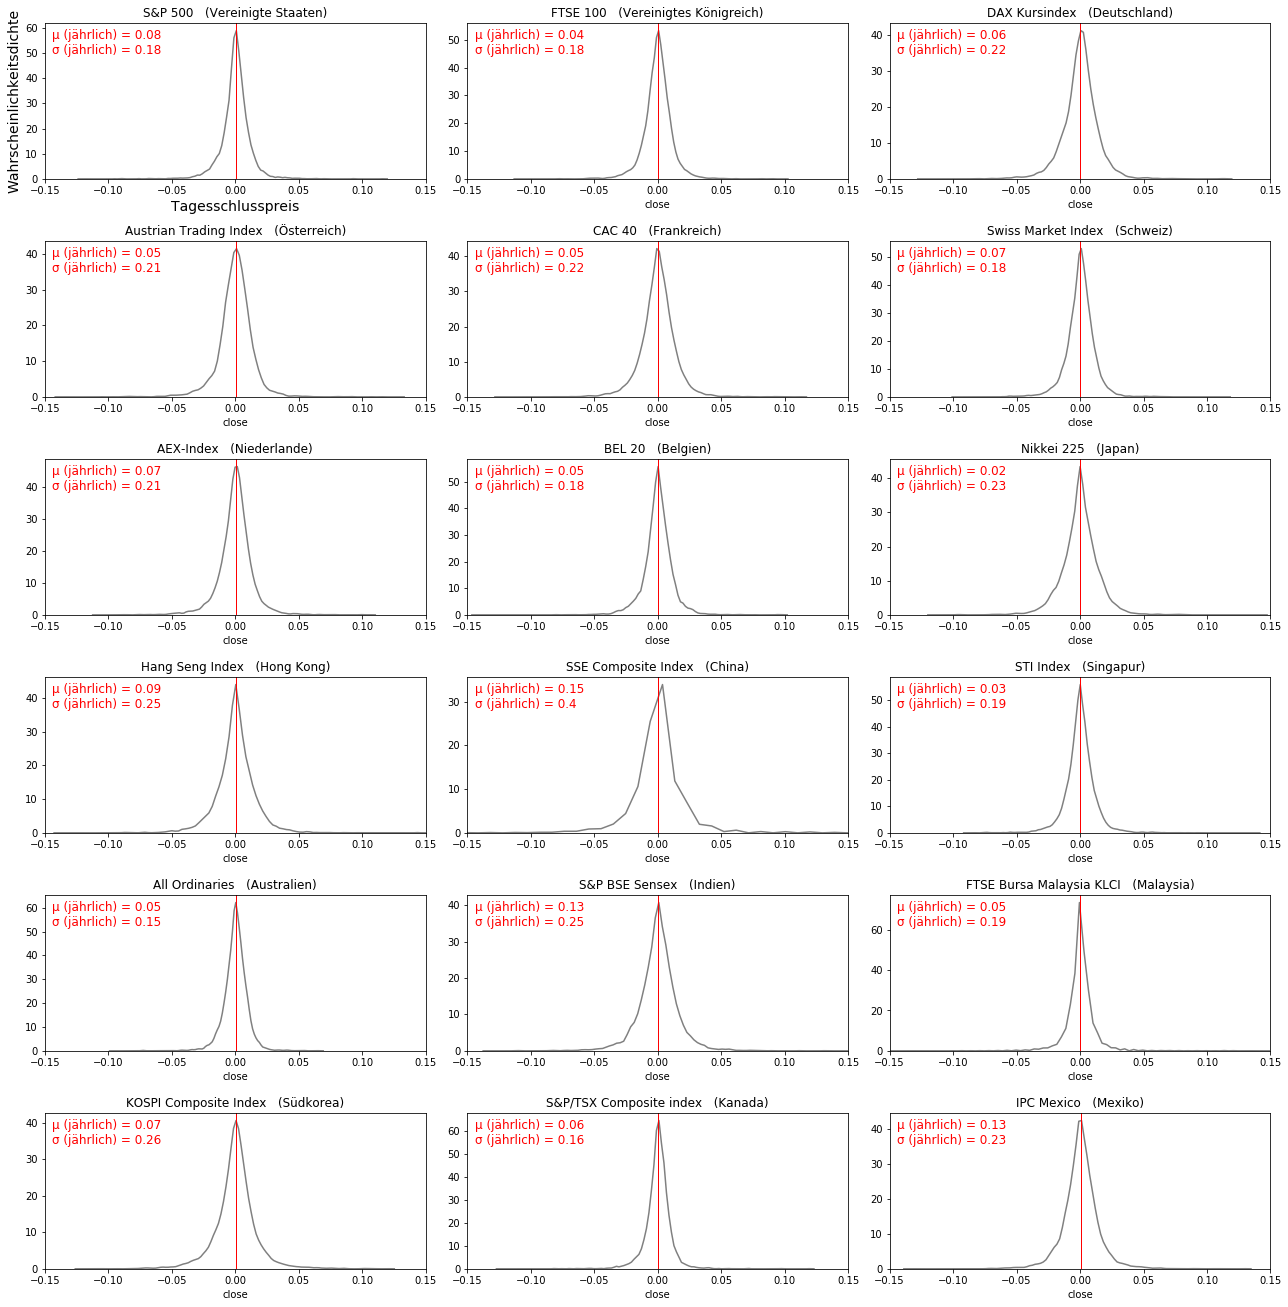

In [138]:
plt.figure(figsize = (18,27))

for index, exchange in enumerate(symbols):
    plt.subplot(9,3,index+1)
    plotdata = data[exchange]["close"]
    plotdata = plotdata.pct_change()
    plotdata = plotdata.dropna()
    sns.distplot(plotdata, color = "grey", hist = False)
    plt.xlim(-0.15,0.15)
    plt.axvline(x = plotdata.mean(), color = "red", linewidth = 1)
    plt.title(symbol_to_name[exchange]+"   ({})".format(translate_countries(symbol_to_country[exchange])), fontsize = 12)
    plt.annotate("µ (jährlich) = {}".format(round(plotdata.mean()*250,2)), (0.02,0.9), xycoords = "axes fraction", color = "red", fontsize = 12)
    plt.annotate("σ (jährlich) = {}".format(indices.loc[symbol_to_name[exchange],"Volatilität p.a."]), (0.02,0.8), xycoords = "axes fraction", color = "red", fontsize = 12)
    if index == 0:
        plt.xlabel("Tagesschlusspreis", fontsize = 14)
        plt.ylabel("Wahrscheinlichkeitsdichte", fontsize = 14)
    
plt.tight_layout()
plt.subplots_adjust(hspace = 0.4)

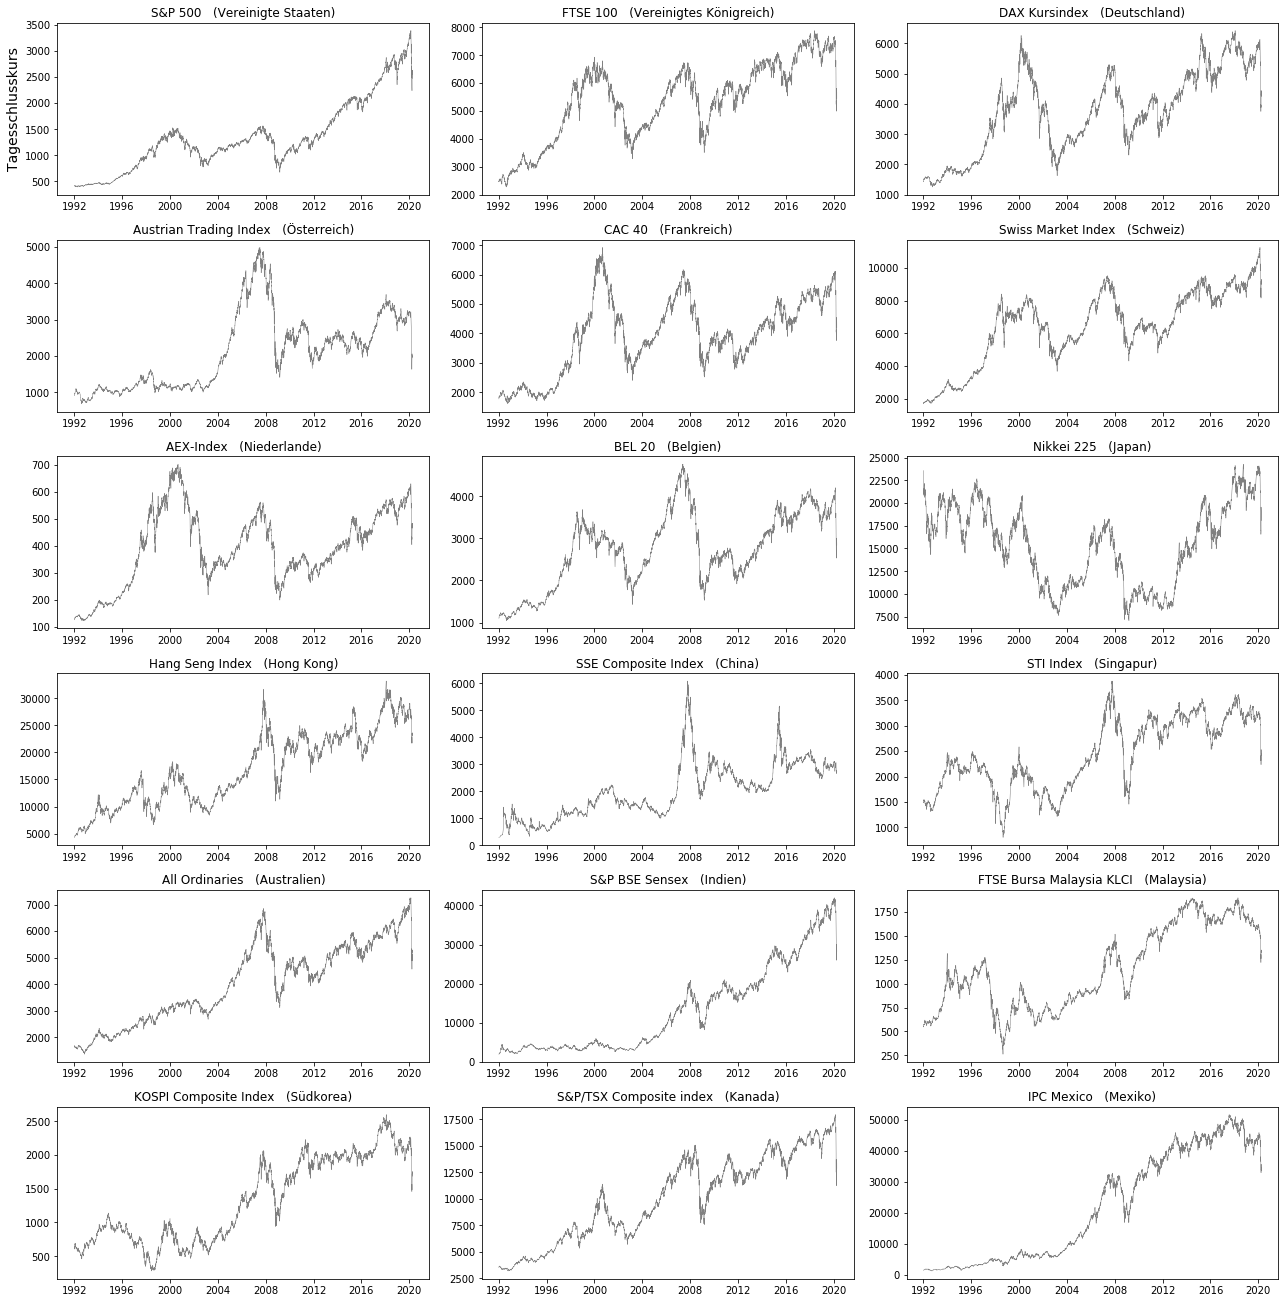

In [139]:
plt.figure(figsize = (18,27))

for index, exchange in enumerate(symbols):
    plt.subplot(9,3,index+1)
    plotdata = data[exchange]["close"]
    plt.plot(plotdata, label = "Tagesschlusspreis", color = "grey", linewidth = 0.5)
    plt.title(symbol_to_name[exchange]+"   ({})".format(translate_countries(symbol_to_country[exchange])))
    #plt.legend(frameon = False)
    if index == 0:
        plt.ylabel("Tagesschlusskurs", fontsize = 14)


plt.subplots_adjust(hspace = 0.4)
plt.tight_layout()

## Portfoliotheorie: Bedeutung der Korrelation
<a id='interactivePortfolio'></a>

In [140]:
def portfolio_volatility(x1,x2,s1,s2,cor):
    #returns standard deviation of the portfolio
    #x1,x2 = Anteile
    #s1,s2 = Standardabweichung
    #cor = Korrelation
    return np.sqrt((x1**2*s1**2)+(x2**2*s2**2)+2*cor*x1*x2*s1*s2)

In [141]:
def portfolio_return(x1,x2,r1,r2):
    return x1*r1+x2*r2

In [142]:
#2 assets

@widgets.interact(r1 = widgets.FloatSlider(value=0.05, description='Exp. Return 1', max=0.3, min=0, step = 0.01),
                 r2 = widgets.FloatSlider(value=0.09, description='Exp. Return 2', max=0.3, min=0, step = 0.01),
                  std1 = widgets.FloatSlider(value=0.1, description='Std. Dev 1', max=0.5, min=0, step = 0.01),
                  std2 = widgets.FloatSlider(value=0.2, description='Std. Dev 2', max=0.5, min=0, step = 0.01))
# std1 = 0.1
# std2 = 0.2
# r1 = 0.05
# r2 = 0.09

def portfolio_model(r1 = 0.05, r2 = 0.09, std1 = 0.1, std2 = 0.2, start_value = False):
    
    if start_value == True:
        std1 = 0.1
        std2 = 0.2
        r1 = 0.05
        r2 = 0.09
    
    print("Anlage 1: \n  Rendite = {}\n  Standardabweichung = {}\n".format(r1,std1))
    print("Anlage 2: \n  Rendite = {}\n  Standardabweichung = {}".format(r2,std2))

    share1 = np.arange(0,1.001,0.001)

    ex_cors = np.arange(-1,1.1,0.1)

    fig = plt.figure(figsize = (15,8))

    cmap = matplotlib.cm.bwr

    for i, corr in enumerate(ex_cors):

        volatility_list=[]
        return_list = []

        for share in share1:
            volatility_list.append(portfolio_volatility(share,1-share,std1,std2,corr))
            return_list.append(portfolio_return(share,1-share,r1,r2))


        plt.plot(volatility_list, return_list, label = round(corr,1), linewidth = 1, color = cmap(i/len(ex_cors)))

    plt.legend(frameon = False, title = "Korrelation \u03C1", loc = "center right")
    plt.ylabel("Portfoliorendite µ", fontsize = 12)
    plt.xlabel("Portfoliostandardabweichung σ", fontsize = 12)
    plt.xlim((0,max(std1,std2)*1.1))
    plt.title("Rendite und Standardabweichung eines Portfolios mit 2 Anlagen unter verschiedenen Korrelationen der Komponenten")
    plt.tight_layout()
    
    fig.show()

interactive(children=(FloatSlider(value=0.05, description='Exp. Return 1', max=0.3, step=0.01), FloatSlider(va…

## Inhaltlich für Bachelorarbeit (Grafiken, Tabellen, etc.)

## Globalization index

In [144]:
globalization_index = pd.read_excel("Data/KOF Globalization Index/KOFGI_2019_data.xlsx")
globalization_index = globalization_index[["country","year","KOFGI"]]
globalization_index= globalization_index.pivot(index = "year",columns = "country", values = "KOFGI")

In [145]:
wb_imports = pd.read_csv("Data/Trade/WorldBank_total_imports/World_Bank_Imports.csv", skiprows = 3)
wb_imports.drop(["Country Code","Indicator Name", "Indicator Code", "Unnamed: 64"], axis=1, inplace=True)
wb_imports.set_index("Country Name", inplace = True)

In [146]:
name_global_imports = "Sum of imports worldwide"
name_global_index = "Globalisation Index (World)"

world_summary = pd.DataFrame(wb_imports.loc["World"])
world_summary.rename(columns = {"World":name_global_imports}, inplace = True)
world_summary.index = pd.to_datetime(world_summary.index)

temp_sum = pd.DataFrame(globalization_index["World"])
temp_sum.index = pd.to_datetime(temp_sum.index, format='%Y')
temp_sum.rename(columns = {"World":name_global_index}, inplace = True)

world_summary = world_summary.join(temp_sum)
#world_summary.index = world_summary.index.to_period("Y")
world_summary.dropna(inplace = True)
world_summary[name_global_imports]=world_summary[name_global_imports]/1000000000000

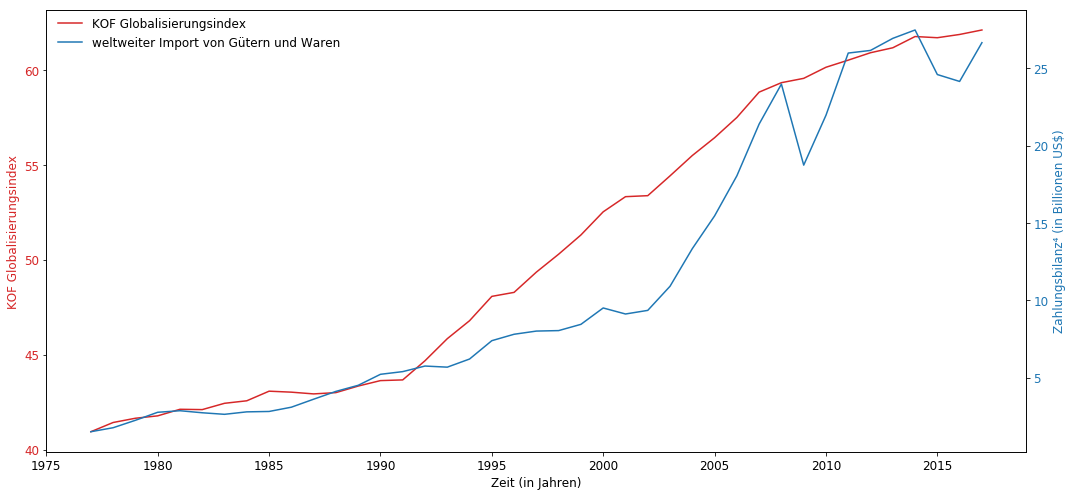

In [147]:
#plot for theoretical background on globalization
t = world_summary.index
data1 = world_summary[name_global_index].to_list()
data2 = world_summary[name_global_imports].to_list()

fig, ax1 = plt.subplots(figsize=(15,7))

color = "tab:red"
ax1.set_xlabel('Zeit (in Jahren)', fontsize = 12)
ax1.set_ylabel('KOF Globalisierungsindex', color=color, fontsize = 12)
ax1.plot(t, data1, color=color, label = "KOF Globalisierungsindex")
ax1.tick_params(axis='y', labelcolor=color, labelsize = 12)
ax1.tick_params(axis='x', labelsize = 12)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Zahlungsbilanz\u2074 (in Billionen US$)', color=color, fontsize = 12)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color, label = "weltweiter Import von Gütern und Waren")
ax2.tick_params(axis='y', labelcolor=color, labelsize = 12)
plt.title("Die Globalisierung anhand verschiedener Indikatoren - eigene Darstellung basierend auf Daten von Gygli et al. (2019) und The World Bank Group (2019)")

fig.tight_layout()  
fig.legend(loc = (0.05,0.86), frameon=False, fontsize = 12)

In [148]:
#Korrelation KOF and World Imports
sp.stats.pearsonr(data1, data2)

(0.9631352660223755, 7.595564285093394e-24)

### interaktive Darstellung Indexkorrelation und Globalisierungsindikator 
<a id='interactiveLaender'></a>

In [150]:
#Zusammenhang zwischen wirtschaftlicher Integration und Korrelation zwischen Aktienindizes darstellen
country_to_symbol = dict(zip(symbol_to_country.values(),symbol_to_country.keys()))

@widgets.interact(index1 = widgets.Dropdown(options = countries, value = "USA", description = "Land 1"), 
                  index2 = widgets.Dropdown(options = countries, value = "Germany", description = "Land 2"), 
                  lag = widgets.IntSlider(min = -10, max = 10, step = 1, value = 0, description = "Lag", continuous_update=False),
                 indicator_trade = widgets.ToggleButtons(options = ["absoluter Handel","relativer Handel"], description = "Indikator"))


def lag_plot(index1 = "USA", index2 = "Germany", lag = 0, plot = True, indicator_trade = "absoluter Handel"):
      
    
    plt.close()

    index1 = country_to_symbol[index1]
    index2 = country_to_symbol[index2]
    
    try:
        temp_pair = index1 + " + " + index2
        temp = results[temp_pair]["dataframe"][:]
    except:
        temp_pair = index2 + " + " + index1
        temp = results[temp_pair]["dataframe"][:]        
    
    try:
        temp.index = temp.index.to_timestamp()
    except:
        pass

    #plot for theoretical background on globalization
    if lag == 0:
        t = temp.index
    elif lag >0:
        t = temp.index[lag:]
    elif lag <0:
        t = temp.index[:lag]
    
    if indicator_trade == "absoluter Handel":
        data1 = temp["total imports"].to_list()
        bezeichnung = "gesamter Handel"
        beschriftung_y = "bilateraler Gesamthandel"
    elif indicator_trade == "relativer Handel":
        data1 = temp["Trade-to-GDP"].to_list()
        bezeichnung = "relativer Handel"
        beschriftung_y = "Anteil des bilateralen Handelsvolumens am gemeinsamen BIP"
        
    data2 = temp["Correlation({})".format(window)].to_list()

    if lag != 0:
        data1,data2 = shift_data(data1,data2,lag)
            
    if plot == False:
        print("Korrelation:", sp.stats.pearsonr(data1, data2)[0])
        print("P-Wert:", sp.stats.pearsonr(data1, data2)[1])    
    else:
        fig, ax1 = plt.subplots(figsize=(15,7))

        color = "tab:red"
        ax1.set_xlabel('Zeit', fontsize = 12)
        ax1.set_ylabel('Korrelation', color=color, fontsize = 12)
        ax1.plot(t, data2, color=color, label = "Korrelation zwischen den Indizes")
        ax1.tick_params(axis='y', labelcolor=color, labelsize = 12)
        ax1.tick_params(axis='x', labelsize = 12)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel(beschriftung_y, color=color, fontsize = 12)  # we already handled the x-label with ax1
        ax2.plot(t, data1, color=color, label = bezeichnung)
        ax2.tick_params(axis='y', labelcolor=color, labelsize = 12)

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.legend(loc = (0.05,0.86), frameon=False, fontsize = 12)

        print("Korrelation:", sp.stats.pearsonr(data1, data2)[0])
        print("P-Wert:", sp.stats.pearsonr(data1, data2)[1])
        
        plt.title("Korrelation der Indizes und {} zwischen {} ({}) und {} ({})".format(bezeichnung,symbol_to_name[index1], 
                                                                       translate_countries(symbol_to_country[index1]), 
                                                                       symbol_to_name[index2], 
                                                                       translate_countries(symbol_to_country[index2])),
                     fontsize = 14)

interactive(children=(Dropdown(description='Country 1', options=('USA', 'UK', 'Germany', 'Austria', 'France', …

Maximale Korrelation (0.476) bei der Verschiebung der y-Zeitreihe um 6 Jahr(e)


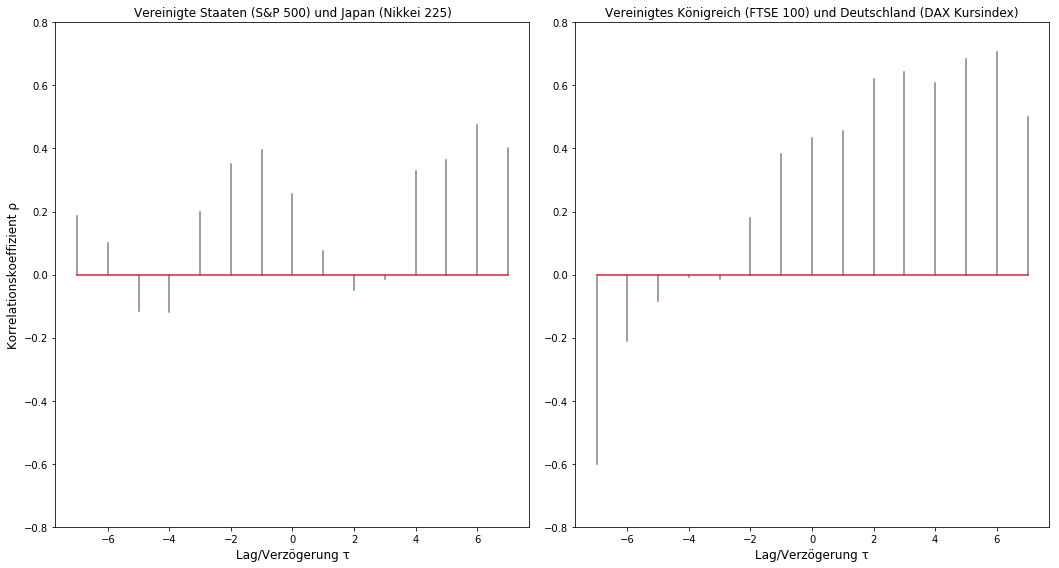

In [151]:
#Berechnung der Korrelation unter verschiedenen Verzögerungen
#Auswahl der Indizes/Länder

index1 = "^GSPC" 
index2 = "^N225"
temp_pair = index1 + " + " + index2

country1 = symbol_to_country[index1]
country2 = symbol_to_country[index2]
country1 = translate_countries(country1)
country2 = translate_countries(country2)

temp = results[temp_pair]["dataframe"][:]

#Berechnung
number_lags = 7
datarange = np.arange(number_lags*-1,number_lags + 1)

lagcorrelation = []
for lag in datarange:
    data1,data2 = shift_data(temp["total imports"].to_list(),temp["Correlation({})".format(window)].to_list(),lag)
    lagcorrelation.append(sp.stats.pearsonr(data1, data2)[0])

maxcor = max(lagcorrelation)
maxlag = dict(zip(lagcorrelation, datarange))[maxcor]

print("Maximale Korrelation ({}) bei der Verschiebung der y-Zeitreihe um {} Jahr(e)".format(round(maxcor,3),maxlag))

#plot 1. Paar
# sns.barplot(datarange, lagcorrelation, palette = "Blues")
plt.figure(figsize = (15,8))
plt.subplot(1,2,1)
plt.stem(datarange, lagcorrelation, "grey", markerfmt=" ")
plt.ylim(-0.8,0.8)
plt.title("{} ({}) und {} ({})".format(country1,symbol_to_name[index1],country2, symbol_to_name[index2]))
plt.xlabel('Lag/Verzögerung \u03C4', fontsize=12)
plt.ylabel('Korrelationskoeffizient \u03C1', fontsize=12)

#2. Paar

index1 = "^FTSE" 
index2 = "^GDAXIP"
temp_pair = index1 + " + " + index2

country1 = symbol_to_country[index1]
country2 = symbol_to_country[index2]
country1 = translate_countries(country1)
country2 = translate_countries(country2)

temp = results[temp_pair]["dataframe"][:]

lagcorrelation = []
for lag in datarange:
    data1,data2 = shift_data(temp["total imports"].to_list(),temp["Correlation({})".format(window)].to_list(),lag)
    lagcorrelation.append(sp.stats.pearsonr(data1, data2)[0])

maxcor = max(lagcorrelation)
maxlag = dict(zip(lagcorrelation, datarange))[maxcor]

plt.subplot(1,2,2)
plt.stem(datarange, lagcorrelation, "grey", markerfmt=" ")
plt.ylim(-0.8,0.8)
plt.title("{} ({}) und {} ({})".format(country1,symbol_to_name[index1],country2, symbol_to_name[index2]))
plt.xlabel('Lag/Verzögerung \u03C4', fontsize=12)

plt.tight_layout()

In [152]:
shift_data([1,2,3],[4,5,6],1)

(array([2, 3]), array([4, 5]))

##### alternative Weg zur Berechnung der jährlichen Korrelation

In [155]:
if run_annual_correlation == True:
    #testen ob sich verschiedene Methoden zur Ermittlung der Korrelation unterscheiden 

    #prepare data1 - gleiches Vorgehen wie oben
    temp_pair = "^GSPC + ^GDAXIP"

    movcor_df = pd.DataFrame(pairs[temp_pair])
    movcor_df.index = movcor_df.index.to_period("y")
    movcor_df = movcor_df.groupby(movcor_df.index).mean() 

    data1 = movcor_df[0].to_list() #gleitend ermittelt über Median
    data2 = annual_correlation[temp_pair]["Korrelation"] #jährlich auf Basis der Indexwerte
    t = annual_correlation[temp_pair].index.to_list()

    plt.figure(figsize = (15,7))
    plt.plot(t,data1, color = "tab:blue", label = "ermittelt über jährlichen Median des gleitenden Durchschnittes")
    plt.plot(t,data2, color = "tab:red", label = "ermittelt direkt aus den historischen Indexwerten jeden Jahres")
    plt.legend(frameon = False)

    print("Korrelation")
    sp.stats.pearsonr(data1, data2)

In [156]:
date = "1992-01-07"
date2 = "2020-04-01"

all_index = pd.DataFrame(data["^GSPC"].loc[date:date2,"close"])
all_index.rename(columns = {"close":"^GSPC"}, inplace = True)

for element in list(symbols)[1:]:
    all_index=all_index.join(data[element].loc[date:date2,"close"])
    all_index.rename(columns = {"close":element}, inplace = True)

In [157]:
#alle Indizes mit Startwert 100

for element in all_index.columns:
    all_index["change"]=all_index[element].pct_change()+1

    for index, row in enumerate(all_index.index):
        if index == 0:
            all_index.loc[row,"change "+element]=100
            prev = 100
        else:
            all_index.loc[row,"change "+element]=prev * all_index.loc[row,"change"]
            prev = all_index.loc[row,"change "+element]
del all_index["change"]

In [158]:
# alle Indizes mit Startwert 100 darstellen
# plt.figure(figsize = (25,8))

# for element in list(all_index.columns):
#     if element[:6]!="change":
#         continue
#     else:
#         plt.plot(all_index[element], label = symbol_to_name[element[7:]])

# plt.legend()

In [159]:
for element in symbols:
    std = all_index[element].std()
    mean = all_index[element].mean()
    all_index["normalized {}".format(element)]=(all_index[element]-mean)/std
all_index.fillna(method = "ffill", inplace = True)

normalized_columns = []
for element in all_index.columns:
    if element[:10]=="normalized":
        normalized_columns.append(element)
all_index["mean normalized"] = all_index[normalized_columns].mean(axis = 1)

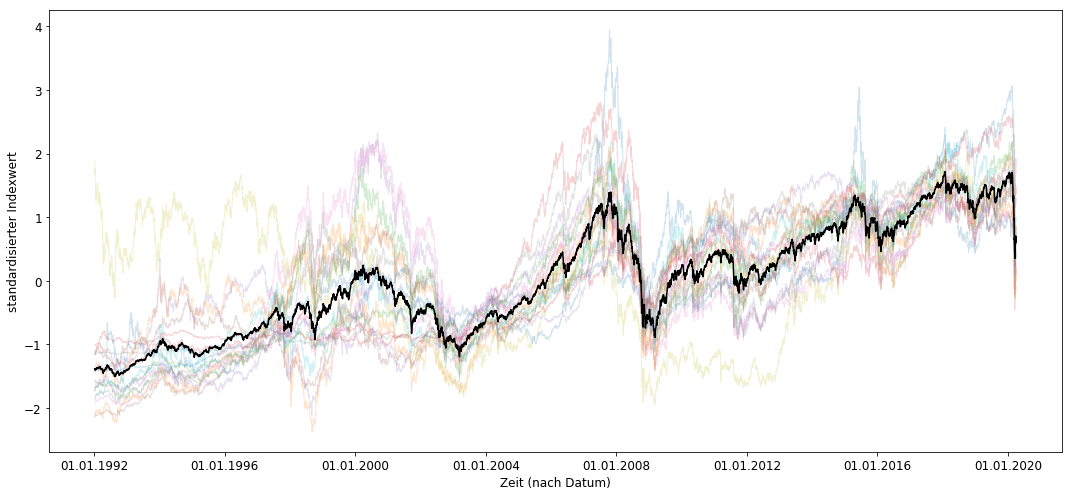

In [160]:
plt.figure(figsize = (15,7))

for element in list(all_index.columns):
    if element == "mean normalized":
        plt.plot(all_index[element], color = "black")
    elif element[:10]!="normalized":
        continue
    else:
        plt.plot(all_index[element], label = symbol_to_name[element[11:]], alpha = 0.2, linewidth = 1)


plt.xlabel("Zeit (nach Datum)", fontsize = 12)
plt.ylabel("standardisierter Indexwert", fontsize = 12)
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d.%m.%Y'))
plt.tick_params(labelsize = 12)
plt.title("standardisierter Verlauf der Aktienindizes ")
plt.tight_layout()

### Korrelation Indizes in einem Land

In [162]:
us_indices = {}
usa = ["^GSPC","^DJI","^MID","^SML","^RUT"]
usa_names = ["S&P 500","Dow Jones","S&P MidCap 400","S&P SmallCap 600","Russell 2000"]

freq = "daily" #daily, weekly or monthly

start_day = "1992-01-01"
end_day = "2020-04-01"

ticker_yahoofinancials = YahooFinancials(usa)
ticker_his = ticker_yahoofinancials.get_historical_price_data(start_day,end_day,freq)

for element in usa:    
    df = pd.DataFrame(ticker_his[element]["prices"])
    df = df[["formatted_date","close","high","low","volume"]] #only closing prices
    df.rename(columns = {"formatted_date":"date"}, inplace = True) 
    #df.rename(columns = {"close":element}, inplace = True)
    df["date"]=pd.to_datetime(df["date"])
    df.set_index("date", inplace = True)
    us_indices[element]=df
    us_indices[element]["close"].fillna(method = "backfill", inplace = True)
    print("Added {}".format(element))
    
#Korrelationen berechnen
df_us = pd.DataFrame(columns = usa, index = usa)

for element in us_indices.keys():
    for element2 in us_indices.keys():
        if element == element2:
            continue
        df_us.loc[element,element2] = sp.stats.pearsonr(us_indices[element]["close"],us_indices[element2]["close"])[0]

df_us.index = usa_names
df_us.columns = usa_names

df_us = df_us.apply(pd.to_numeric).round(3)

print("\nKorrelationen USA:")
df_us

Added ^GSPC
Added ^DJI
Added ^MID
Added ^SML
Added ^RUT

Korrelationen USA:


,S&P 500,Dow Jones,S&P MidCap 400,S&P SmallCap 600,Russell 2000
S&P 500,NaN,0.994,0.960,0.958,0.967
Dow Jones,0.994,NaN,0.973,0.972,0.977
S&P MidCap 400,0.960,0.973,NaN,0.997,0.996
S&P SmallCap 600,0.958,0.972,0.997,NaN,0.997
Russell 2000,0.967,0.977,0.996,0.997,NaN


In [164]:
de_indices = {}
de = ["^GDAXI","^MDAXI","^SDAXI"]
de_names = ["DAX","MDAX","SDAX"]

freq = "daily" #daily, weekly or monthly

start_day = "2014-01-01"
end_day = "2020-04-01"

ticker_yahoofinancials = YahooFinancials(de)
ticker_his = ticker_yahoofinancials.get_historical_price_data(start_day,end_day,freq)

for element in de:    
    df = pd.DataFrame(ticker_his[element]["prices"])
    df = df[["formatted_date","close","high","low","volume"]] #only closing prices
    df.rename(columns = {"formatted_date":"date"}, inplace = True) 
    #df.rename(columns = {"close":element}, inplace = True)
    df["date"]=pd.to_datetime(df["date"])
    df.set_index("date", inplace = True)
    de_indices[element]=df
    de_indices[element]["close"].fillna(method = "backfill", inplace = True)
    print("Added {}".format(element))
    
#Korrelationen berechnen
df_de = pd.DataFrame(columns = de, index = de)

for element in de_indices.keys():
    for element2 in de_indices.keys():
        if element == element2:
            continue
        df_de.loc[element,element2] = sp.stats.pearsonr(de_indices[element]["close"],de_indices[element2]["close"])[0]

df_de.index = de_names
df_de.columns = de_names

df_de = df_de.apply(pd.to_numeric).round(3)

print("\nKorrelationen Deutschland:")
df_de

Added ^GDAXI
Added ^MDAXI
Added ^SDAXI

Korrelationen Deutschland:


,DAX,MDAX,SDAX
DAX,NaN,0.935,0.910
MDAX,0.935,NaN,0.986
SDAX,0.910,0.986,NaN


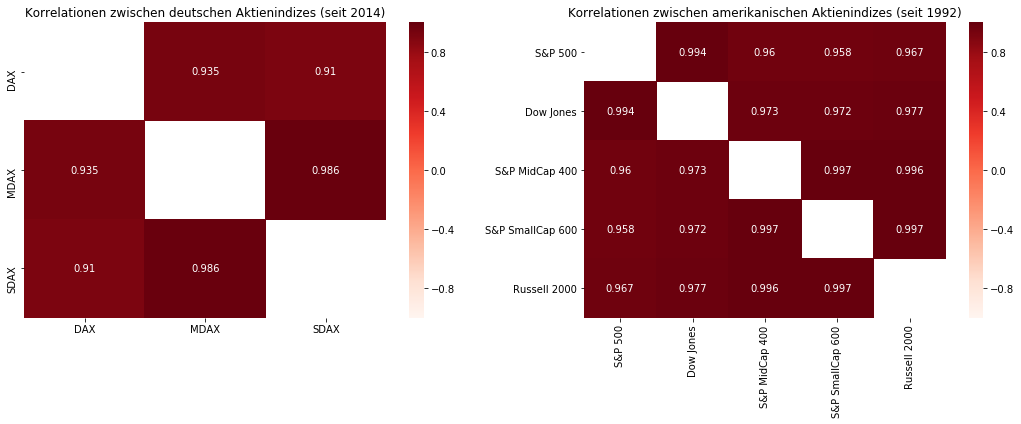

In [165]:
plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
sns.heatmap(df_de, annot = True, cmap = "Reds", 
            mask = df_de > 1-0.0000000000001, 
            vmax = 1.0, vmin = -1.0, fmt='g')
plt.title("Korrelationen zwischen deutschen Aktienindizes (seit 2014)")

plt.subplot(1,2,2)
sns.heatmap(df_us, annot = True, cmap = "Reds", 
            mask = df_us > 1-0.0000000000001, 
            vmax = 1.0, vmin = -1.0, fmt='g')
plt.title("Korrelationen zwischen amerikanischen Aktienindizes (seit 1992)")

plt.subplots_adjust(wspace = 0.5)
plt.tight_layout()